In [ ]:
!pip install pycaret
# !pip install numpy==1.23.5


In [ ]:
# check python version
!python --version

Python 3.11.11


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
import joblib
import json
from pycaret.classification import *


In [ ]:
#file_path = '/content/drive/My Drive/MBP1413-Project/diabetic_data.csv'

diabetic_df = pd.read_csv('/content/drive/My Drive/MBP1413-Project/diabetic_data.csv')

print(diabetic_df.shape)

diabetic_df.head(5)

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
# Check outcome variable

print(diabetic_df.shape)

diabetic_df['readmitted'].value_counts()


(101766, 50)


,count
readmitted,
NO,54864
>30,35545
<30,11357


In [ ]:
# variable type
diabetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# **EDA**

#### Visualize missing values

In [ ]:
diabetic_df.replace('?', pd.NA, inplace=True) # missing values for object columns are labelled as "?", replace with NA
diabetic_df.replace('Unknown/Invalid', pd.NA, inplace=True) # replace unknown gender with NA

# Print the number of missing values for
na_counts = diabetic_df.isna().sum()
print(na_counts)

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

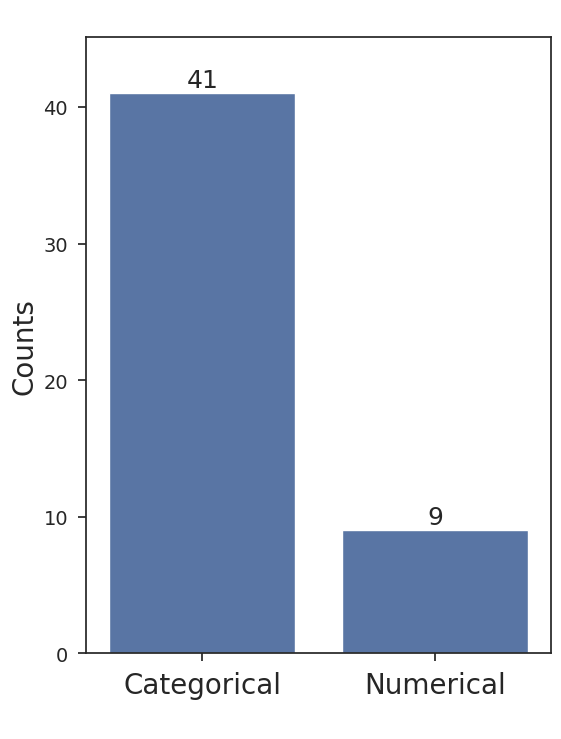

In [ ]:
# Check datatype distribution
datatype_counts = diabetic_df.dtypes.value_counts()
num_features = ['gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications']

# Prepare mapping based on feature names instead of datatypes
# Create DataFrame with feature counts
feature_counts = diabetic_df.dtypes.value_counts()
feature_names = diabetic_df.dtypes.index.tolist()

# Classify features manually
feature_types = ['Numerical' if feature in num_features else 'Categorical' for feature in feature_names]

# Count the number of features in each category
from collections import Counter
type_counts = Counter(feature_types)

# Prepare for plotting
labels = list(type_counts.keys())
counts = list(type_counts.values())

plt.figure(figsize=(6, 8))
ax = sns.barplot(x=labels, y=counts)

plt.xlabel(" ", size = 18)
plt.ylabel("Counts", size=20)
plt.title(" ", size=19)
plt.xticks(rotation=0, size=20)
plt.yticks(size=14)

plt.ylim(0, max(counts) * 1.1)

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.1,
            f'{count}', ha='center', va='bottom', fontsize=18)

plt.show()




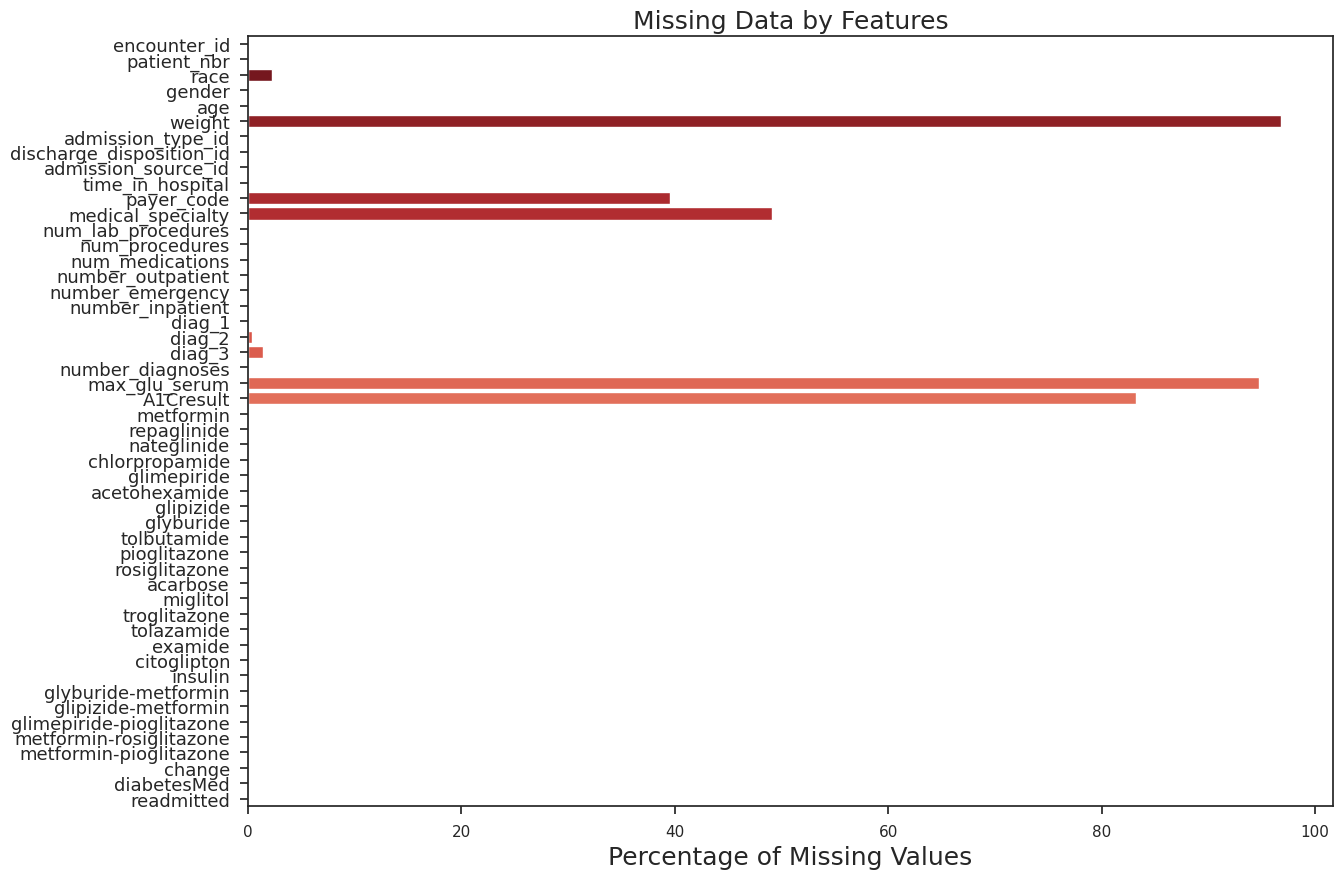

In [ ]:
# Plot percentage of missing data for all features
na_percentage = (na_counts / len(diabetic_df)) * 100
na_df = pd.DataFrame({"Feature": na_counts.index, "Missing Percentage": na_percentage}).reset_index(drop=True)

plt.figure(figsize=(14, 10))

sns.barplot(y="Feature", x="Missing Percentage", hue = 'Feature', data=na_df, palette="Reds_r")
plt.xlabel("Percentage of Missing Values", size = 18)
plt.ylabel("")
plt.tick_params(axis='y', labelsize=13)
plt.title("Missing Data by Features", size = 18)
plt.show()

In [ ]:
# Remove the variables that contain more than 30% of missing values
cols_missing_val = na_df[na_df['Missing Percentage'] > 30]['Feature']
# print(cols_missing_val)
diabetic_df_filtered = diabetic_df.drop(columns=cols_missing_val).copy()

# Remove the variables that contains the same values - so they do not provide useful discriminatory information
diabetic_df_filtered = diabetic_df_filtered.drop(['citoglipton', 'examide'], axis = 1)

# encounter_id and patient_nbr do not carry useful information for re-admission, so we drop them as well
diabetic_df_filtered = diabetic_df_filtered.drop(['encounter_id', 'patient_nbr'], axis = 1)

# For computation, we drop the rest columns with lots of missing values - race, diag_1, diag_2, diag_3
diabetic_df_filtered = diabetic_df_filtered.drop(['race'], axis = 1)

# remove the rows with missing Gender data
diabetic_df_filtered = diabetic_df_filtered.dropna(subset=['gender', 'diag_1', 'diag_2', 'diag_3'])


# Check the selected variables again
na_counts = diabetic_df_filtered.isna().sum()
print(na_counts)

gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide-metformin         0
glipizide-

## Visualizing data imbalance


Readmitted (<30 days): 11250


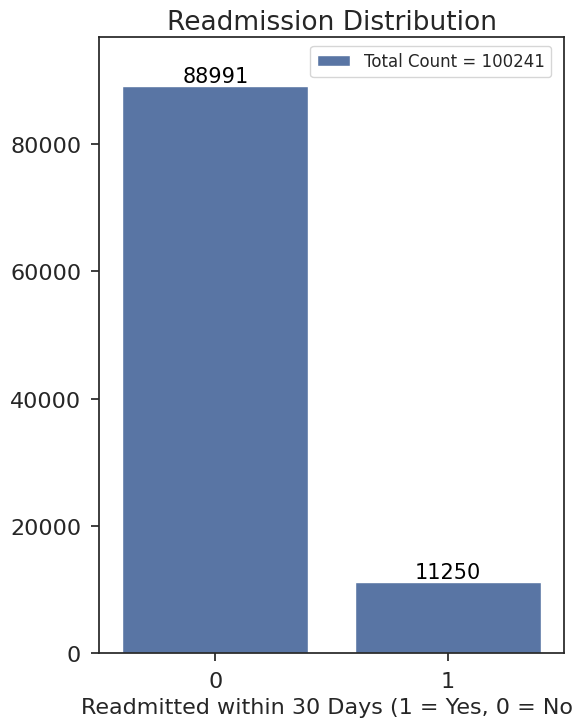

In [ ]:
diabetic_df_filtered['readmitted'] = [1 if x == diabetic_df_filtered['readmitted'][11] else 0 for x in diabetic_df_filtered['readmitted']]
print(f"Readmitted (<30 days): {len(diabetic_df_filtered[diabetic_df_filtered['readmitted'] ==1])}")

plt.figure(figsize=(6, 8))
ax = sns.countplot(x=diabetic_df_filtered['readmitted'])

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=15, color='black')
# Add manual text-only legend (with a box, no color)
tot_count = len(diabetic_df_filtered['readmitted'])
plt.legend([f'Total Count = {tot_count}'],
           loc='upper right',
           bbox_to_anchor=(0.99, 1),  # Push legend outside plot
           frameon=True,              # Show the box
           fontsize=12)


plt.title("Readmission Distribution", size=19)
plt.xlabel("Readmitted within 30 Days (1 = Yes, 0 = No)", size=16)
plt.ylabel("", size = 16)
plt.ylim(0, 96700)
plt.xticks(size=16)
plt.yticks(size=16)

plt.show()


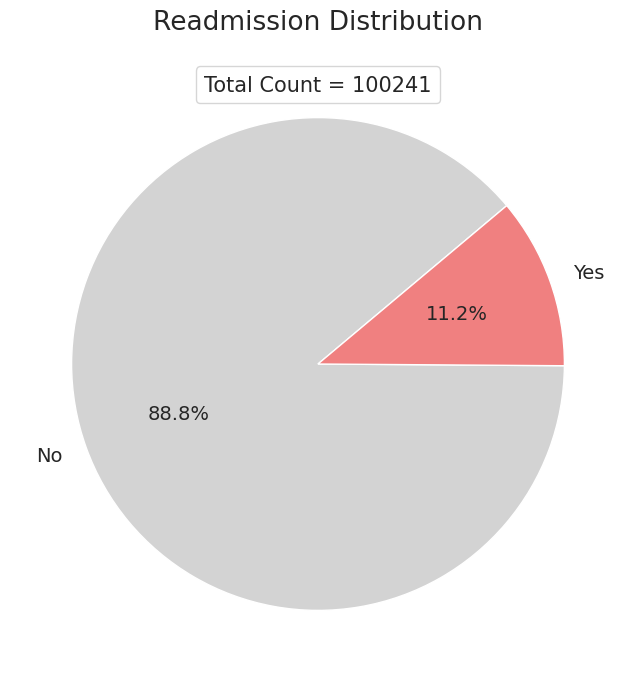

In [ ]:
# Prepare data
readmit_counts = diabetic_df_filtered['readmitted'].value_counts()
labels = ['No', 'Yes']
sizes = [readmit_counts[0], readmit_counts[1]]
colors = ['lightgrey', 'lightcoral']  # Optional custom colors

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Show percentages
    startangle=40,     # Start from top
    colors=colors,
    textprops={'fontsize': 14}
)

total_count = len(diabetic_df_filtered)
# Add a box "legend" manually
plt.legend([f'Total Count = {total_count}'],
           loc='upper center',
           bbox_to_anchor=(0.5, 1),
           frameon=True,
           fontsize=15,
           handlelength=0,      # Remove line/marker length
           handletextpad=0      # Remove padding between marker and text
          )

plt.title("Readmission Distribution", size=19, y=1.03 )
plt.show()


# Feature Engineering



#### Feature Encoding

In [ ]:
# List the selected variables and check their types
diabetic_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100241 entries, 1 to 101765
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   gender                    100241 non-null  object
 1   age                       100241 non-null  object
 2   admission_type_id         100241 non-null  int64 
 3   discharge_disposition_id  100241 non-null  int64 
 4   admission_source_id       100241 non-null  int64 
 5   time_in_hospital          100241 non-null  int64 
 6   num_lab_procedures        100241 non-null  int64 
 7   num_procedures            100241 non-null  int64 
 8   num_medications           100241 non-null  int64 
 9   number_outpatient         100241 non-null  int64 
 10  number_emergency          100241 non-null  int64 
 11  number_inpatient          100241 non-null  int64 
 12  diag_1                    100241 non-null  object
 13  diag_2                    100241 non-null  object
 14  diag_3   

Here we performed encoding for categorical variables

In [ ]:
diabetic_df['medical_specialty']

,medical_specialty
0,Pediatrics-Endocrinology
1,<NA>
2,<NA>
3,<NA>
4,<NA>
...,...
101761,<NA>
101762,<NA>
101763,<NA>
101764,Surgery-General


In [ ]:
diabetic_df_encoded = diabetic_df_filtered.copy()

# TODO: race (one-hot encoding? race_AfricanAmerican, race_Asian, race_Caucasian, etc)\
#race_mapping = {'Caucasian': 0, 'AfricanAmerican': 1, 'Asian': 2, 'Hispanic': 3, 'Other': 4}
#diabetic_df_encoded = pd.get_dummies(diabetic_df_encoded, columns=['race'])

# gender
diabetic_df_encoded['gender'] = diabetic_df_filtered['gender'].map({'Female': 1, 'Male': 0})

# age
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
diabetic_df_encoded['age'] = diabetic_df_filtered['age'].map(age_mapping)

# weight
#weight_mapping = {
#    '[0-25)': 0, '[25-50)': 1, '[50-75)': 2, '[75-100)': 3, '[100-125)': 4
#    , '[125-150)': 5, '[150-175)': 6, '[175-200)': 7, '>200': 8
#}
#diabetic_df_encoded['weight'] = diabetic_df['weight'].map(weight_mapping)


# admission_source_id
# 9-Unknown/Invalid: 9, 15, 17, 20, 21
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 9 if x in (15, 17, 20, 21) else x)
# 1-Physician/Clinic Referral:1, 2, 3
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 1 if x in (2,3) else x)
# 4-Transfer from Hospital: 4, 10, 22
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 4 if x in (10,22) else x)
# 5-Transfer from Facility:5, 6, 18, 19, 25, 26
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 5 if x in (6, 18, 19, 25, 26) else x)
# 11-Delivery:11, 12, 13, 14
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 11 if x in (12, 13, 14) else x)

# admission_type_id; group Null
diabetic_df_encoded['admission_type_id']=diabetic_df_encoded['admission_type_id'].apply(lambda x : 5 if x in (6,8) else x)
diabetic_df_encoded['admission_type_id']=diabetic_df_encoded['admission_type_id'].apply(lambda x : 1 if x in (1,2) else x)

# discharge_disposition_id
#Discharged Home: 1, 6, 8
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 1 if x in (6,8) else x)
#Uncategorized/Unknown: 18, 25, 26, 12
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 18 if x in (25,26,12) else x)
#Expired:11, 19, 20, 21
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 11 if x in (19,20,21) else x)
#Hospice:13, 14
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 13 if x ==14 else x)
# Discharged/Transferred to Hospital: 2, 9, 10, 23, 27, 28, 29
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 2 if x in ( 9, 10, 23, 27, 28, 29) else x)
#Discharged/Transferred to Care Facility: 3, 4, 5, 15, 24
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 3 if x in ( 4, 5, 15, 24) else x)
#Discharged to Outpatient Services:16, 17
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 16 if x ==17 else x)

# ENCODE MEDICATION BY TYPE
medication_columns = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
     "insulin", "glyburide-metformin", "glipizide-metformin",
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
]
diabetic_df_encoded[medication_columns] = diabetic_df_filtered[medication_columns].map(
    lambda x: 0 if x == 'Down' else 1 if x == 'No' else 2 if x == 'Steady' else 3
)

# change of medications
diabetic_df_encoded['change'] = diabetic_df_filtered['change'].map({'Ch': 1, 'No':0})

# prescribed diabetes medications
diabetic_df_encoded['diabetesMed'] = diabetic_df_filtered['diabetesMed'].map({'No':0, 'Yes':1})

# readmitted: encoded in EDA

In [ ]:
# all three diag features have more than 800 values unique we are grouping them based on ICD-9 codes
# https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

diag1_list=[]
diag2_list=[]
diag3_list=[]
# This function, diag_cluster, takes a column 'col' and a list 'diag_list' as inputs.
# It iterates through each value in the 'col' column of the DataFrame 'df' and assigns a cluster value based on certain conditions.
# The resulting cluster values are appended to the 'diag_list'.

def diag_cluster(col, diag_list):
    for x in diabetic_df_encoded[col]:
        # If the value in the 'col' column contains 'V' or 'E', it is assigned a cluster value of 18.
        if 'V' in x or 'E' in x:
            diag_list.append(18)
            continue
        # The following conditions assign cluster values based on specific ranges of float values.
        elif 1 <= float(x) <= 139.9:
            diag_list.append(1)
        elif 140 <= float(x) <= 239.9:
            diag_list.append(2)
        elif 240 <= float(x) <= 279.9:
            diag_list.append(3)
        elif 280 <= float(x) <= 289.9:
            diag_list.append(4)
        elif 290 <= float(x) <= 319.9:
            diag_list.append(5)
        elif 320 <= float(x) <= 389.9:
            diag_list.append(6)
        elif 390 <= float(x) <= 459.9:
            diag_list.append(7)
        elif 460 <= float(x) <= 519.9:
            diag_list.append(8)
        elif 520 <= float(x) <= 579.9:
            diag_list.append(9)
        elif 580 <= float(x) <= 629.9:
            diag_list.append(10)
        elif 630 <= float(x) <= 679.9:
            diag_list.append(11)
        elif 680 <= float(x) <= 709.9:
            diag_list.append(12)
        elif 710 <= float(x) <= 739.9:
            diag_list.append(13)
        elif 740 <= float(x) <= 759.9:
            diag_list.append(14)
        elif 760 <= float(x) <= 779.9:
            diag_list.append(15)
        elif 780 <= float(x) <= 799.9:
            diag_list.append(16)
        elif 800 <= float(x) <= 999.9:
            diag_list.append(17)

diag_cluster('diag_1',diag1_list)
diag_cluster('diag_2',diag2_list)
diag_cluster('diag_3',diag3_list)
diabetic_df_encoded['diag_1']=diag1_list
diabetic_df_encoded['diag_2']=diag2_list
diabetic_df_encoded['diag_3']=diag3_list

In [ ]:
diabetic_df_encoded

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,1,15,1,1,7,3,59,0,18,0,...,1,3,1,1,1,1,1,1,1,0
2,1,25,1,1,7,2,11,5,13,2,...,1,1,1,1,1,1,1,0,1,0
3,0,35,1,1,7,2,44,1,16,0,...,1,3,1,1,1,1,1,1,1,0
4,0,45,1,1,7,1,51,0,8,0,...,1,2,1,1,1,1,1,1,1,0
5,0,55,1,1,1,3,31,6,16,0,...,1,2,1,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,75,1,3,7,3,51,0,16,0,...,1,0,1,1,1,1,1,1,1,0
101762,1,85,1,3,5,5,33,3,18,0,...,1,2,1,1,1,1,1,0,1,0
101763,0,75,1,1,7,1,53,0,9,1,...,1,0,1,1,1,1,1,1,1,0
101764,1,85,1,3,7,10,45,2,21,0,...,1,3,1,1,1,1,1,1,1,0


##### One Hot

In [ ]:
cat_cols = ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
            'diag_1', 'diag_2', 'diag_3',  # include diag1/2/3
            'metformin', 'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
            'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin',
            'glyburide-metformin', 'glipizide-metformin',
            'glimepiride-pioglitazone', 'metformin-rosiglitazone',
            'metformin-pioglitazone', 'change', 'diabetesMed']

diabetic_df_one_hot = pd.get_dummies(diabetic_df_encoded, columns=cat_cols
                                     , drop_first=True
                                     )
diabetic_df_one_hot = diabetic_df_one_hot.map(lambda x: 0 if x == False else 1 if x == True else x)

# comment out if diag1/2/3 is included in cat_cols
# diabetic_df_one_hot = diabetic_df_one_hot.drop(columns=['diag_1', 'diag_2', 'diag_3'])

one_hot_cat_list = diabetic_df_one_hot.iloc[:,10:].columns.to_list()

### Feature EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your features
num_features = diabetic_df_encoded.iloc[:, :9].columns.to_list()
num_features = num_features + ['readmitted']

plt.figure(figsize=(12, 9))

# Plot heatmap and explicitly assign cbar
heatmap = sns.heatmap(diabetic_df_encoded[num_features].corr(), cmap="coolwarm", linewidths=0.2, cbar_kws={'shrink': 0.8})

plt.title("Feature Correlation Heatmap", size=20)
plt.xticks(rotation=60, size=22)
plt.yticks(rotation=0, size=22)

# Safely access the color bar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=16)

# Clean up axis labels: remove '_id'
clean_labels = [label.replace('_id', '').replace('_', ' ').title() for label in num_features]

# Set cleaned labels
heatmap.set_xticklabels(clean_labels, rotation=60, size=18)
heatmap.set_yticklabels(clean_labels, rotation=0, size=18)

plt.tight_layout()
plt.show()



NameError: name 'diabetic_df_encoded' is not defined

In [ ]:
num_features

['gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'readmitted']

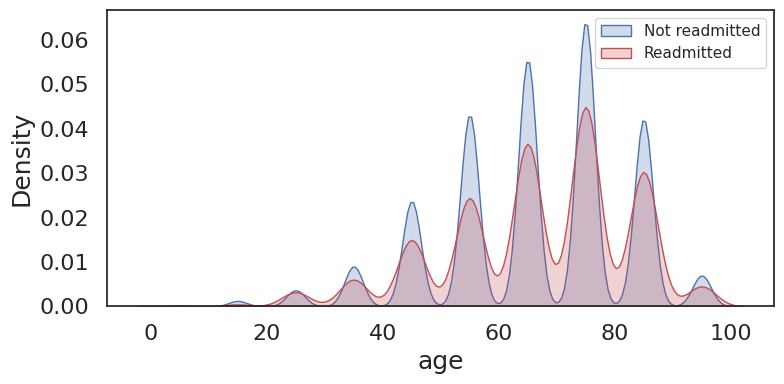

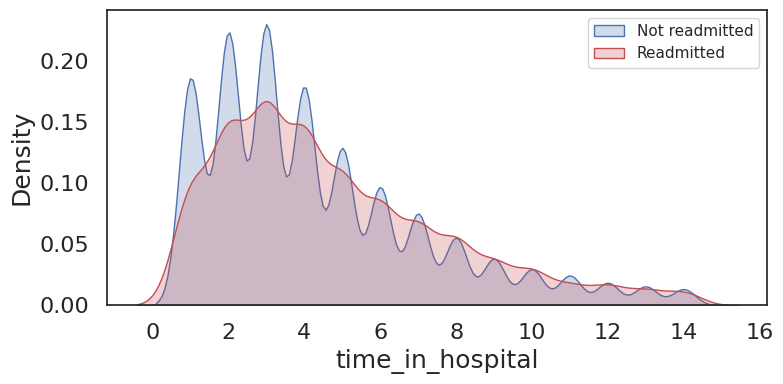

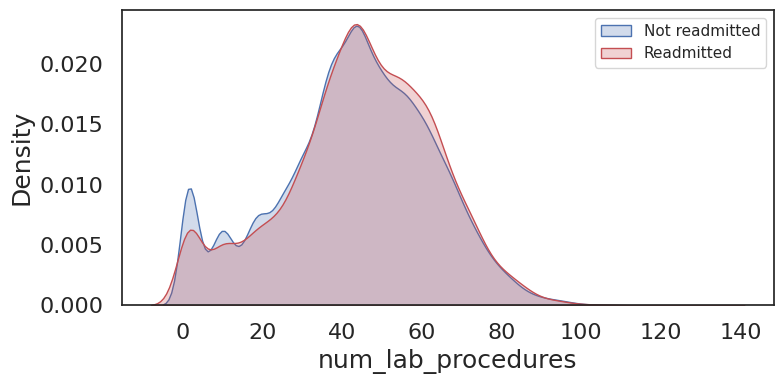

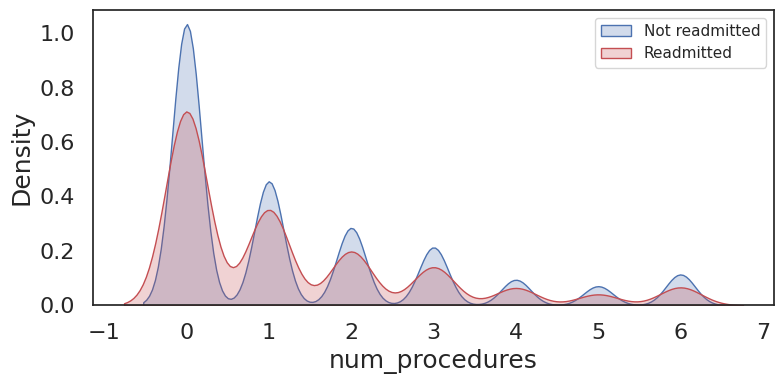

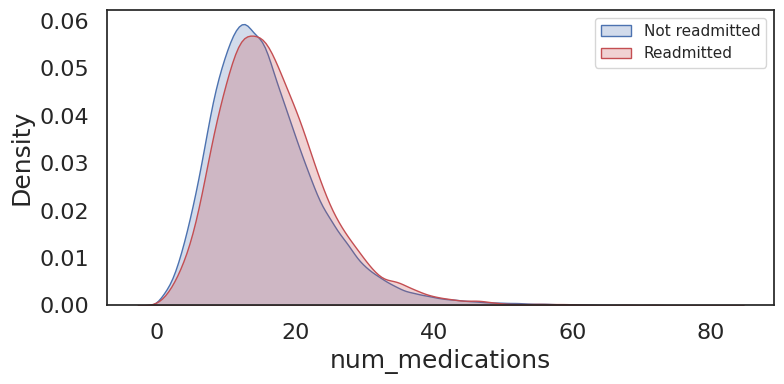

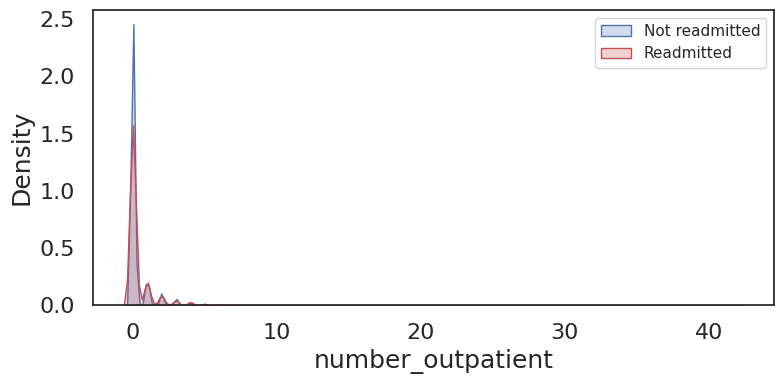

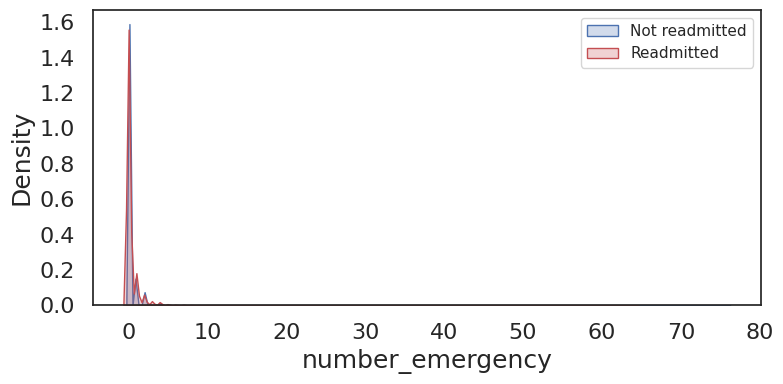

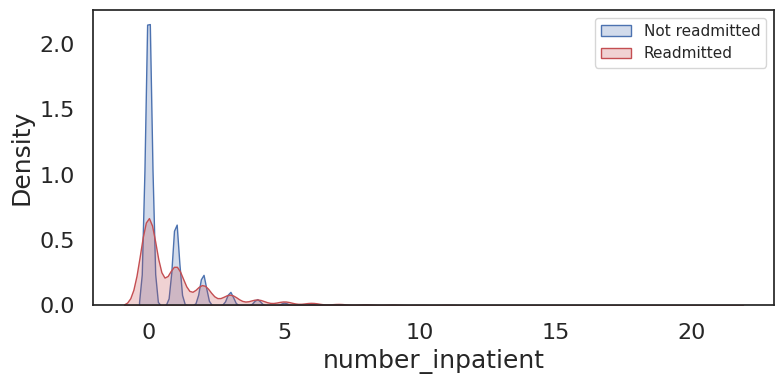

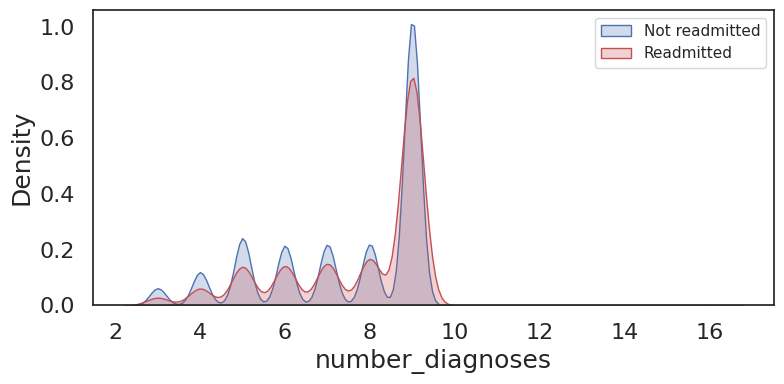

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set global plot style
sns.set(style="white")

# List of categorical and numerical features (based on your column names)
categorical_features = [
    'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3'
]

numerical_features = ['age',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

# # Plot for categorical features
# for feature in categorical_features:
#     plt.figure(figsize=(8, 4))
#     sns.countplot(y=diabetic_df_encoded[feature], hue=diabetic_df_encoded['readmitted'])
#     plt.title(f'{feature} vs Readmission')
#     plt.xlabel('Count')
#     plt.ylabel(feature)
#     plt.legend(title='Readmitted', labels=['No', 'Yes'])
#     plt.tight_layout()
#     plt.show()

# Plot for numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 0, feature],
        shade=True, color='b', label='Not readmitted'
    )
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 1, feature],
        shade=True, color='r', label='Readmitted'
    )
    plt.title(f'')
    plt.xlabel(feature, size = 18)
    plt.ylabel('Density', size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()


In [ ]:
import os

# Create a folder to save images
os.makedirs('numerical_feature_plots', exist_ok=True)
sns.set(style="white")

# Loop and save each plot
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 0, feature],
        shade=True, color='b', label='Not readmitted'
    )
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 1, feature],
        shade=True, color='r', label='Readmitted'
    )
    plt.title(f' ')
    plt.xlabel(feature, size=20)
    plt.ylabel('Density', size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    # plt.legend()
    plt.tight_layout()

    # Save the figure
    filename = f'numerical_feature_plots/{feature}_readmission.png'
    plt.savefig(filename, dpi=300)  # You can increase dpi for better resolution

    plt.close()  # Close the figure to save memory

print("All plots saved in 'numerical_feature_plots' folder!")


All plots saved in 'numerical_feature_plots' folder!


In [ ]:
from google.colab import files
import shutil

# Zip the folder
shutil.make_archive('numerical_feature_plots', 'zip', 'numerical_feature_plots')

# Download
files.download('numerical_feature_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preprocessing Selection

## Train-val-test split

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(df, target_col='readmitted', test_size=0.2, val_size=0.2, random_state=42):
    # Split independent and dependent variables
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # First split: Train+Val vs Test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Second split: Train vs Val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size, stratify=y_trainval, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
# train test split for diabetic_df_encode
X_train_encoded, X_val_encoded, X_test_encoded, y_train_encoded, y_val_encoded, y_test_encoded = split_data(diabetic_df_encoded)

# train test split for diabetic_df_one_hot
X_train_onehot, X_val_onehot, X_test_onehot, y_train_onehot, y_val_onehot, y_test_onehot = split_data(diabetic_df_one_hot)


## Define function for model evaluation

In [ ]:
# define a funtion for model evaluation
def evaluate_model(y_true, y_pred, y_prob, name):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prc = average_precision_score(y_true, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "Model": name,
        "Accuracy": acc,
        'Precision': prec,
        "Sensitivity": rec,
        "Specificity": specificity,
        "F1 Score": f1,
        "AUROC": auc,
        "AUPRC": prc
    }


## Test Encoding Method on Classification performance

Use LogReg as baseline model (class_weight = "balanced")

#### Baseline Function for Log Reg

In [ ]:
def train_log_reg(X_train, y_train, X_val, y_val, evaluate_model, class_weight = None, model_name="Logistic Regression"):
  """
  Function to train a logistic regression model, serving as our baseline model
  """
  log_reg = Pipeline([
    ('scaler', StandardScaler()), # standardize features to std = 1 and mean = 0
    ('clf', LogisticRegression(max_iter=1000,
                               class_weight=class_weight,  # address class imbalance by class weight
                               random_state=42
                               )
    )
  ])
  log_reg.fit(X_train, y_train)
  y_log_prob = log_reg.predict_proba(X_val)[:, 1]

  fpr, tpr, thresholds = roc_curve(y_val, y_log_prob)
  youden_j = tpr - fpr
  best_index = np.argmax(youden_j)
  optimal_threshold = thresholds[best_index]

  # Evaluate the model
  y_pred_thres = (y_log_prob >= optimal_threshold).astype(int)

  evaluation_results = evaluate_model(y_val, y_pred_thres, y_log_prob, model_name)
  evaluation_results['Threshold'] = optimal_threshold

  return log_reg, evaluation_results

### Test One-Hot Encoding

In [ ]:
# Balanced, ONEHOT
best_log_reg, log_reg_metrics = train_log_reg(
    X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, One-hot"
)

log_reg_metrics

{'Model': 'Logistic Regression, One-hot',
 'Accuracy': 0.6057110792443419,
 'Precision': 0.16469018677734953,
 'Sensitivity': 0.6172222222222222,
 'Specificity': 0.6042559168480932,
 'F1 Score': 0.2600046805523052,
 'AUROC': 0.6551726088754671,
 'AUPRC': 0.21391298378947732,
 'Threshold': 0.47127195538153355}

### Test Label Encoding

In [ ]:
# Balanced, Multi-class Encode
best_log_reg, log_reg_metrics = train_log_reg(
    X_train_encoded, y_train_encoded, X_val_encoded, y_val_encoded, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, Multi-class encoded"
)

log_reg_metrics

{'Model': 'Logistic Regression, Multi-class encoded',
 'Accuracy': 0.6850177691876053,
 'Precision': 0.17270531400966183,
 'Sensitivity': 0.4766666666666667,
 'Specificity': 0.7113561345600112,
 'F1 Score': 0.25354609929078015,
 'AUROC': 0.6280000936395346,
 'AUPRC': 0.19838755055443014,
 'Threshold': 0.5065975264788174}

### Conclusion: **One Hot** is better
(Higher F1 score)

## Reduce numerical feature skewness
Conclusion: reducing skewness decrease performance

In [ ]:
## Reduce skewness on X_train_onehot

num_features = X_train_onehot.iloc[:, :9].columns.to_list()

skewed_feats = X_train_onehot[num_features].skew().sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 1].index.tolist()

skewed_feats

,0
number_emergency,23.026480
number_outpatient,8.775721
number_inpatient,3.535090
num_medications,1.339987
num_procedures,1.309100
time_in_hospital,1.120713
num_lab_procedures,-0.232675
age,-0.556568
number_diagnoses,-0.802688


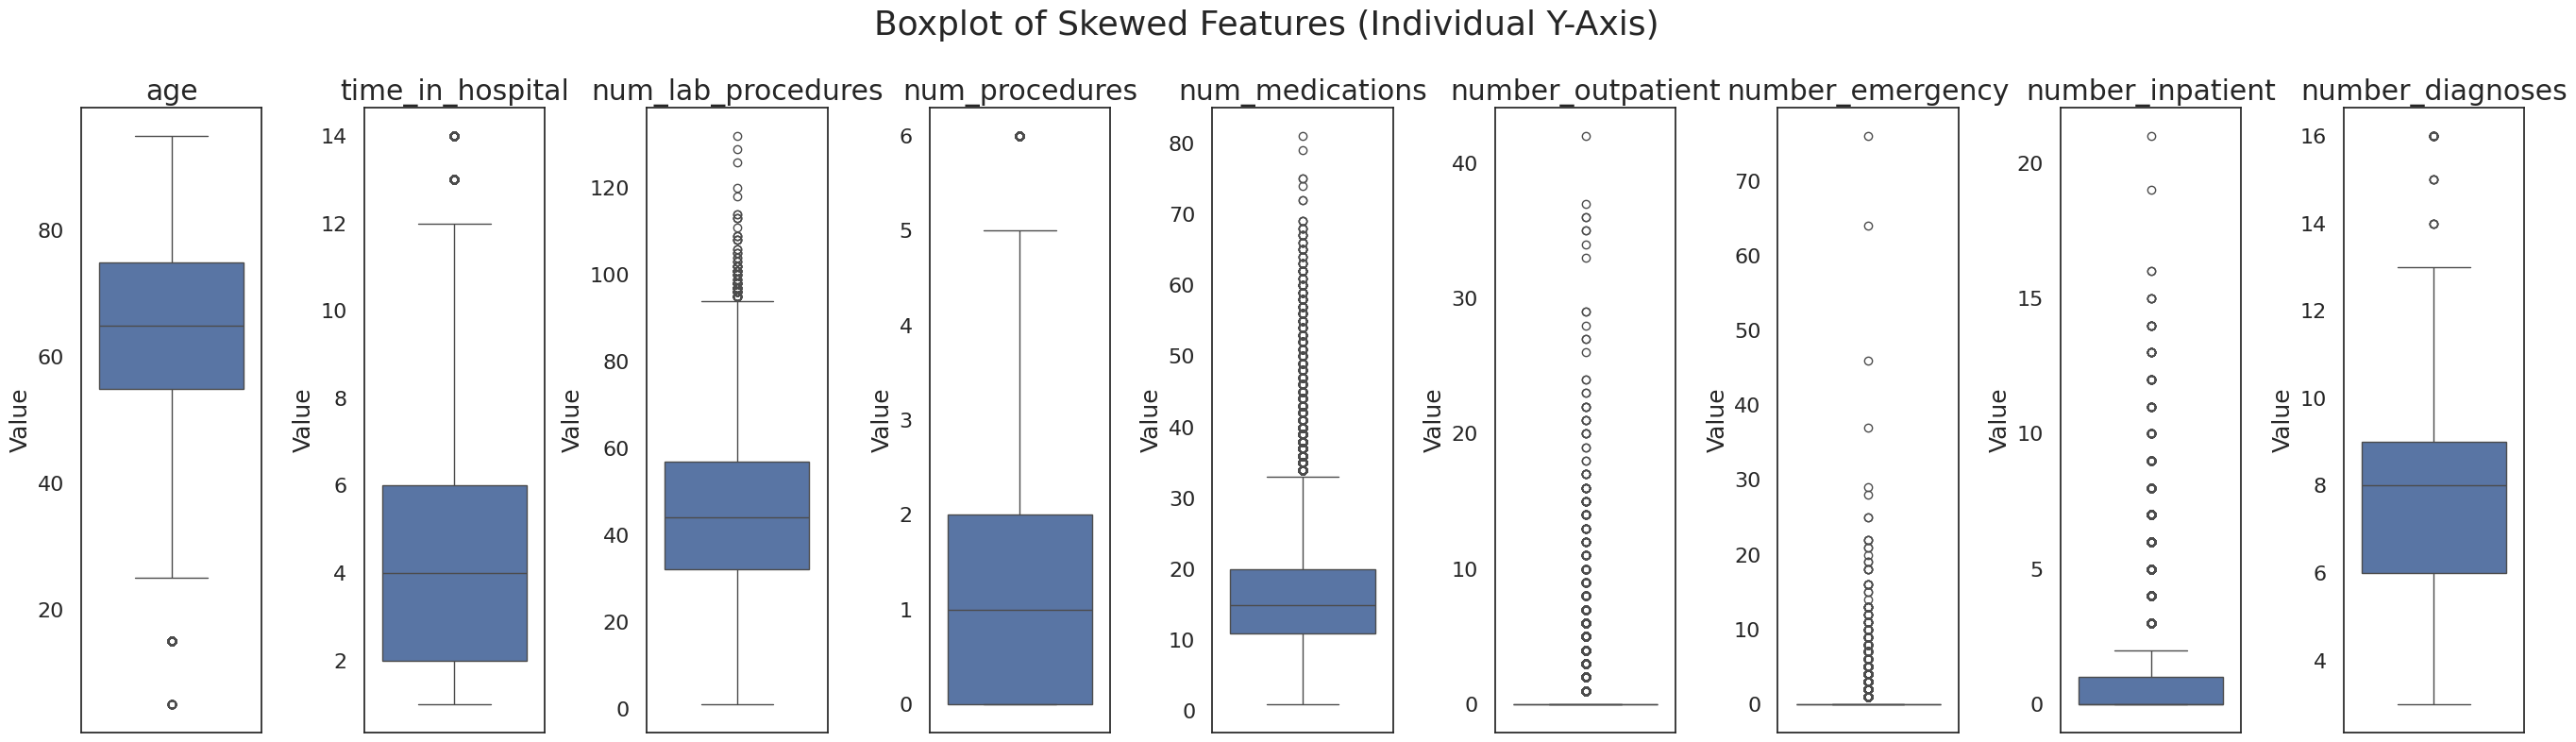

In [ ]:
# Prepare melted DataFrame
melted_df = X_train_onehot[num_features].melt(var_name='Feature', value_name='Value')

# Get unique features
features = melted_df['Feature'].unique()

# Set up subplots
fig, axes = plt.subplots(1, len(features), figsize=(3 * len(features), 8), sharey=False)

# Plot each feature individually
for ax, feature in zip(axes, features):
    sns.boxplot(data=melted_df[melted_df['Feature'] == feature], x='Feature', y='Value', ax=ax)
    ax.set_title(feature, fontsize=21.5)
    ax.set_xlabel('')  # Remove x-axis label (optional)
    ax.tick_params(axis='x', labelbottom=False)  # Optional: remove x tick labels
    ax.set_ylabel('Value', fontsize=18)
    ax.tick_params(axis='y', labelsize=16)

# Global figure title
plt.suptitle('Boxplot of Skewed Features (Individual Y-Axis)', fontsize=26)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust for suptitle
plt.show()




In [ ]:
X_train_onehot_unskewed = X_train_onehot.copy()

for col in skewed_cols:
    # Add 1 to avoid log(0)
    X_train_onehot_unskewed[col] = np.log1p(X_train_onehot[col])

X_train_onehot_unskewed[num_features].skew().sort_values(ascending=False)

,0
number_emergency,3.601987
number_outpatient,2.711070
number_inpatient,1.417706
num_procedures,0.510109
time_in_hospital,0.091814
num_lab_procedures,-0.232675
num_medications,-0.455741
age,-0.556568
number_diagnoses,-0.802688


In [ ]:
# Train logistic regression on unskewed data
best_log_reg_unskewed, log_reg_metrics_unskewed = train_log_reg(
    X_train_onehot_unskewed,
    y_train_onehot,
    X_val_onehot,
    y_val_onehot,
    evaluate_model,
    class_weight=None,
    model_name="Logistic Regression, One Hot, Unskewed"
)

log_reg_metrics_unskewed



{'Model': 'Logistic Regression, One Hot, Unskewed',
 'Accuracy': 0.6250389675166781,
 'Precision': 0.15795454545454546,
 'Sensitivity': 0.5405555555555556,
 'Specificity': 0.6357188004775616,
 'F1 Score': 0.24447236180904522,
 'AUROC': 0.6234233833524514,
 'AUPRC': 0.18957614693890745,
 'Threshold': 0.4931678917544213}

## Test Resampling Method on Classification Performance

Approach 1: introduce diff weight to class1/class 0 in loss function \
- using built-in sklearn weight class

Approach 2: Upsample: SMOTE\
Approach 3: downsample by random selection


### Upsample

In [ ]:
# function to Upsample
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training set
def upsample(X_train, y_train):
    sm = SMOTE(sampling_strategy='minority', random_state=42) # resample only minority class
    X_train_up, y_train_up = sm.fit_resample(X_train, y_train)
    return X_train_up, y_train_up

In [ ]:
# Apply SMOTE to the training set ONLY
X_train_up_onehot, y_train_up_onehot = upsample(X_train_onehot, y_train_onehot)

y_train_up_onehot.value_counts()


,count
readmitted,
0,56953
1,56953


In [ ]:
# Balanced, ONEHOT, Upsampled
best_log_reg_up, log_reg_metrics_up = train_log_reg(
    X_train_up_onehot, y_train_up_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = None, model_name="Logistic Regression, One-Hot, SMOTE-Upsampled"
)

log_reg_metrics_up

{'Model': 'Logistic Regression, One-Hot, SMOTE-Upsampled',
 'Accuracy': 0.588814764012719,
 'Precision': 0.14685520695242305,
 'Sensitivity': 0.5538888888888889,
 'Specificity': 0.5932298616475876,
 'F1 Score': 0.2321574106415182,
 'AUROC': 0.5977593229861647,
 'AUPRC': 0.15688719706619345,
 'Threshold': 0.1080170134716201}

### Downsample

In [ ]:
# Downsample
def downsample(X_train, y_train):
    train_data = pd.concat([X_train, y_train], axis=1)

    majority_class = train_data[train_data['readmitted'] == 0]
    minority_class = train_data[train_data['readmitted'] == 1]

    majority_downsampled = resample(
        majority_class,
        replace=False,  # sample without replacement
        n_samples=len(minority_class),
        random_state=42
    )

    # Combine downsampled majority and full minority class
    train_downsampled = pd.concat([majority_downsampled, minority_class])

    # Shuffle the downsampled training set
    train_downsampled = train_downsampled.sample(frac=1, random_state=28).reset_index(drop=True)

    # Split features and target again
    X_train_down = train_downsampled.drop(columns=['readmitted'])
    y_train_down = train_downsampled['readmitted']

    return X_train_down, y_train_down

In [ ]:
X_train_down_onehot, y_train_down_onehot = downsample(X_train_onehot, y_train_onehot)
y_train_down_onehot.value_counts()

,count
readmitted,
0,7200
1,7200


In [ ]:
# Balanced, ONEHOT, downsampled
best_log_reg_down, log_reg_metrics_down = train_log_reg(
    X_train_down_onehot, y_train_down_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = None, model_name="Logistic Regression, One-Hot, Down-Upsampled"
)

log_reg_metrics_down

{'Model': 'Logistic Regression, One-Hot, Down-Upsampled',
 'Accuracy': 0.6522850551780036,
 'Precision': 0.17377785455173606,
 'Sensitivity': 0.5588888888888889,
 'Specificity': 0.6640915794648501,
 'F1 Score': 0.2651205692449598,
 'AUROC': 0.6506247317617497,
 'AUPRC': 0.20977714894659838,
 'Threshold': 0.49652819858165104}

### compare with class_weight = 'balanced'

In [ ]:
# Balanced, ONEHOT, resampled by class_weight = balanced
best_log_reg, log_reg_metrics = train_log_reg(
    X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, One-Hot"
)

log_reg_metrics

{'Model': 'Logistic Regression, One-Hot',
 'Accuracy': 0.6057110792443419,
 'Precision': 0.16469018677734953,
 'Sensitivity': 0.6172222222222222,
 'Specificity': 0.6042559168480932,
 'F1 Score': 0.2600046805523052,
 'AUROC': 0.6551726088754671,
 'AUPRC': 0.21391298378947732,
 'Threshold': 0.47127195538153355}

### Conclusion: resample by downsampling (Higher F1

### Visualize class distribution of test and train sets

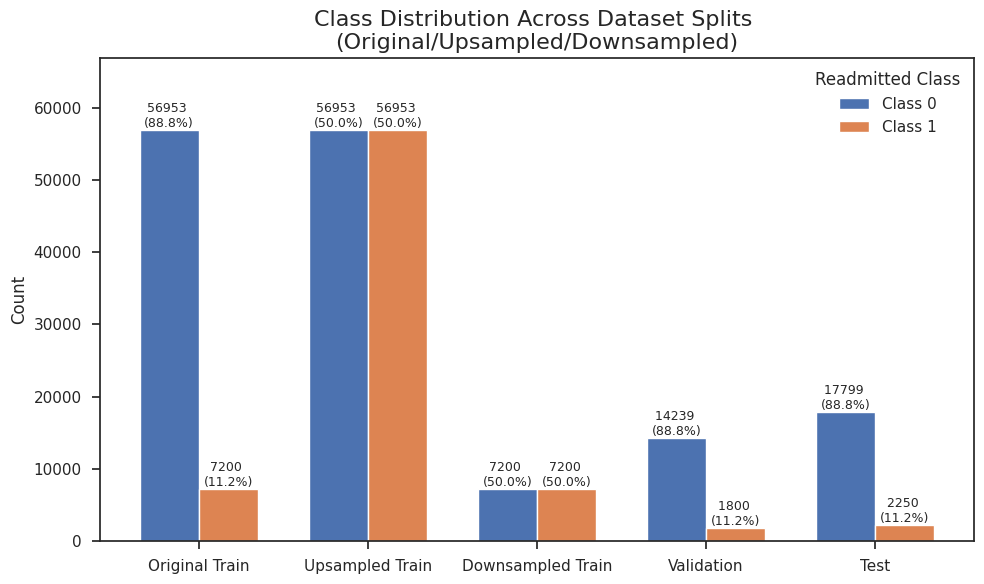

In [ ]:
# Raw counts for each dataset
train_counts = y_train_onehot.value_counts()
val_counts = y_val_onehot.value_counts()
test_counts = y_test_onehot.value_counts()
train_up_counts = y_train_up_onehot.value_counts()
train_down_counts = y_train_down_onehot.value_counts()

# Dataset groups and labels
splits = ['Original Train', 'Upsampled Train', 'Downsampled Train', 'Validation', 'Test']
datasets = [train_counts, train_up_counts, train_down_counts, val_counts, test_counts]
totals = [
    train_counts.sum(),         # Original Train
    train_up_counts.sum(),      # Upsampled Train
    train_down_counts.sum(),    # Downsampled Train
    val_counts.sum(),           # Validation
    test_counts.sum()           # Test
]
x = np.arange(len(splits))
bar_width = 0.35

sns.set(style="ticks")

fig, ax = plt.subplots(figsize=(10, 6))

offsets = {
    0: -bar_width / 2,
    1: bar_width / 2
}

classes = sorted(y_test_onehot.unique())

# Plot bars for each class across all datasets
for cls in classes:
    heights = [ds.get(cls, 0) for ds in datasets]
    positions = x + offsets[cls]
    ax.bar(positions, heights, width=bar_width, label=f'Class {cls}')

    # Add text: count (percentage)
    for i, count in enumerate(heights):
        perc = count / totals[i] * 100
        ax.text(positions[i], count + 20, f"{count} \n({perc:.1f}%)",
                ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(splits, rotation=0)
ax.set_ylabel("Count")
ax.set_title("Class Distribution Across Dataset Splits \n(Original/Upsampled/Downsampled)", size = 16)
ax.set_ylim(0, max(max(train_counts), max(test_counts), max(train_up_counts), max(train_down_counts)) + 10000)
ax.legend(title="Readmitted Class")

plt.tight_layout()
plt.show()


# Feature Subsetting

#### Cramer's V for categorical features

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the modified buildVMatrix function to return both the matrix and vars_to_drop
def buildVMatrix(df):
    l = []
    cat_vars = one_hot_cat_list
    v_mat = pd.DataFrame(index=cat_vars, columns=cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(df[var_one], df[var_two]))
            v_mat.loc[var_one, var_two] = v

            if var_one != var_two and v >= 0.9:
                el = [var_one, var_two]
                el.sort()
                if el[1] not in l:
                    l.append(el[1])

    # Convert v_mat to numeric type for heatmap visualization
    v_mat = v_mat.astype(float)
    return v_mat, l


In [ ]:
from scipy.stats.contingency import association

In [ ]:

# Assuming one_hot_cat_list and X_train_onehot are defined
one_hot_cat_list = diabetic_df_one_hot.iloc[:, 10:].columns.to_list()
v_matrix, vars_to_drop = buildVMatrix(X_train_onehot)

# Print vars_to_drop for reference
print("Variables to drop due to high association (Cramér's V ≥ 0.9):", vars_to_drop)



Variables to drop due to high association (Cramér's V ≥ 0.9): ['metformin_2', 'repaglinide_2', 'nateglinide_2', 'chlorpropamide_2', 'glimepiride_2', 'glipizide_2', 'glyburide_2', 'pioglitazone_2', 'rosiglitazone_2', 'acarbose_2', 'miglitol_2', 'glyburide-metformin_2']


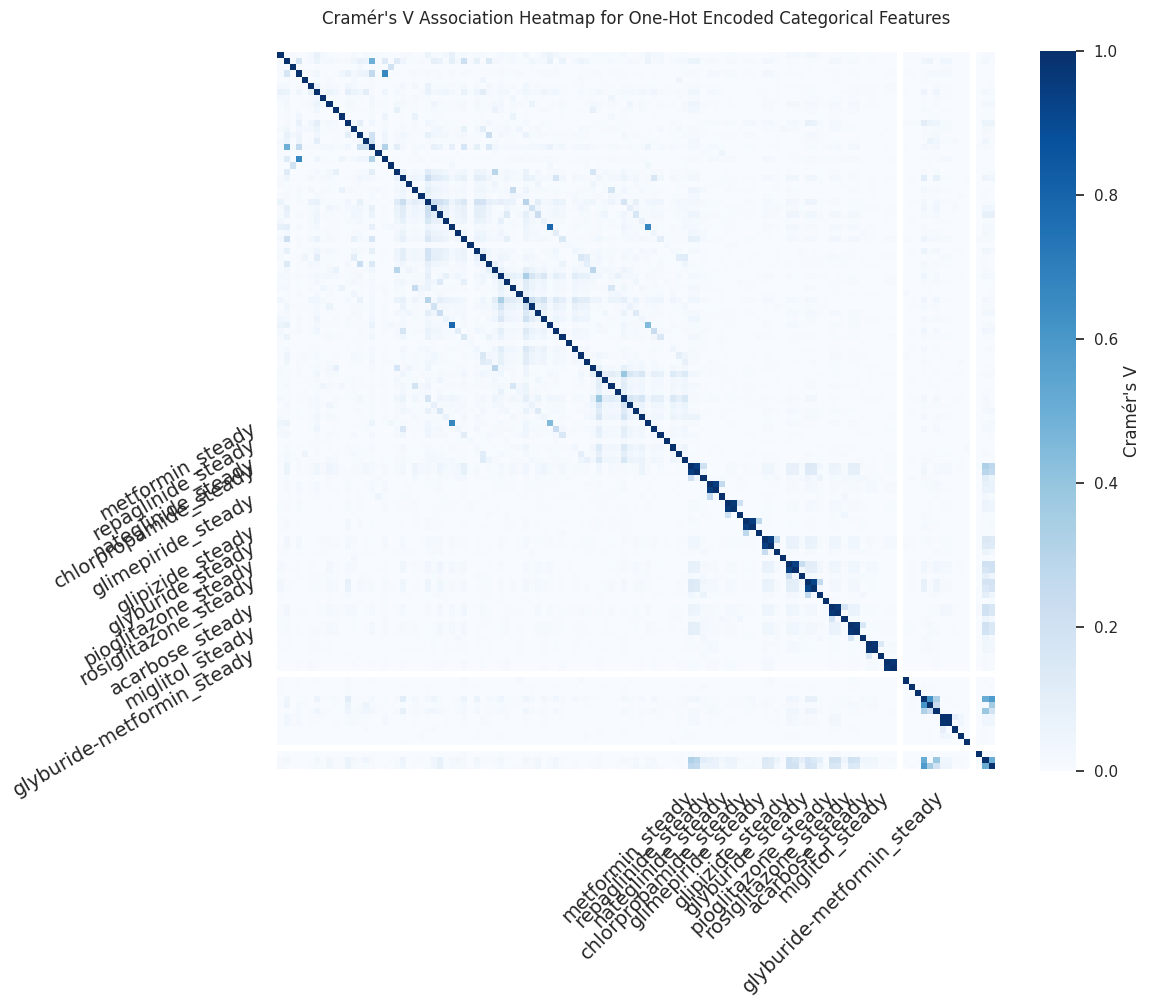

In [ ]:
# Your selected features to show tick labels
selected_features = [
    'metformin_2', 'repaglinide_2', 'nateglinide_2', 'chlorpropamide_2',
    'glimepiride_2', 'glipizide_2', 'glyburide_2', 'pioglitazone_2',
    'rosiglitazone_2', 'acarbose_2', 'miglitol_2', 'glyburide-metformin_2'
]

# Replace '_2' with '_steady' for display
display_features = [feature.replace('_2', '_steady') for feature in selected_features]

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    v_matrix,
    annot=False,
    cmap="Blues",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cramér's V"},
    xticklabels=True,
    yticklabels=True
)

# Step 1: Get all tick labels
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

# Step 2: Update x-axis labels
new_xticklabels = [
    display_features[selected_features.index(label.get_text())] if label.get_text() in selected_features else ''
    for label in xticklabels
]
ax.set_xticklabels(new_xticklabels, rotation=45, ha="right", fontsize=14)

# Step 3: Update y-axis labels
new_yticklabels = [
    display_features[selected_features.index(label.get_text())] if label.get_text() in selected_features else ''
    for label in yticklabels
]
ax.set_yticklabels(new_yticklabels, rotation=30, fontsize=14)

# Title and layout
plt.title("Cramér's V Association Heatmap for One-Hot Encoded Categorical Features", pad=20)
plt.tight_layout()

plt.show()



#### Anova for numerical features

Conclusion: Do not drop any numerical features.

All 9 numerical features are statistically significant (p < 0.001), but the effect size varies a lot. The top 5 features with high Fstat are statistically most discriminative for predicting readmitted.


In [ ]:
from sklearn.feature_selection import f_classif
import pandas as pd

# Step 1: Get the first 9 columns (numerical features)
num_features = diabetic_df_one_hot.iloc[:, :9].columns.to_list()

# Step 2: Separate X and y
X_numeric = diabetic_df_one_hot[num_features]
y = diabetic_df_one_hot['readmitted']

# Step 3: Run ANOVA F-test
F, p = f_classif(X_numeric, y)

# Step 4: Create a DataFrame of results
anova_results = pd.DataFrame({
    'Feature': num_features,
    'F-statistic': F,
    'p-value': p
})

# Step 5: Sort by F-statistic (descending)
anova_results_sorted = anova_results.sort_values(by='F-statistic', ascending=False)

# Display ranked features
print(anova_results_sorted)


              Feature  F-statistic        p-value
7    number_inpatient  2475.644509   0.000000e+00
6    number_emergency   526.049442  4.076133e-116
1    time_in_hospital   240.590155   3.381754e-54
8    number_diagnoses   214.118251   1.947471e-48
4     num_medications   184.224843   6.311561e-42
5   number_outpatient    81.869812   1.478614e-19
2  num_lab_procedures    38.818808   4.668654e-10
0                 age    20.487249   6.009873e-06
3      num_procedures     7.588119   5.876483e-03


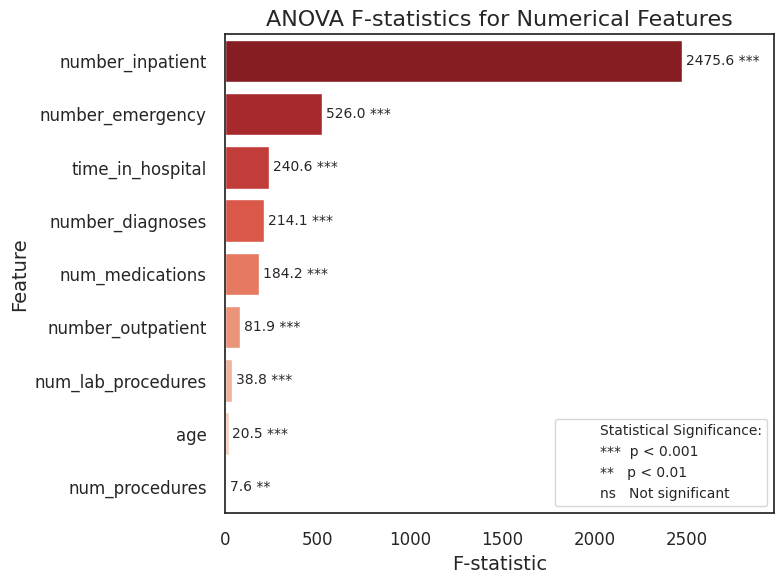

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Step 1: Add a column for significance stars
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'  # not significant

anova_results_sorted['Significance'] = anova_results_sorted['p-value'].apply(significance_stars)

# Step 2: Plot with significance stars
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=anova_results_sorted,
    y='Feature',
    x='F-statistic',
    palette='Reds_r'
)

plt.title('ANOVA F-statistics for Numerical Features', size=16)
plt.xlabel('F-statistic', size=14)
plt.ylabel('Feature', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(0, 1.2 * anova_results_sorted['F-statistic'].max())

# Step 3: Add numbers and significance stars on the bars properly
for bar, (_, row) in zip(ax.patches, anova_results_sorted.iterrows()):
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    text = f"{row['F-statistic']:.1f} {row['Significance']}"
    ax.text(bar_width + 20, bar_y, text, va='center', ha='left', fontsize=10)

# Step 4: Add manual legend for significance stars
legend_elements = [
    Line2D([0], [0], color='none', marker='', label='Statistical Significance:'),
    Line2D([0], [0], color='none', marker='', label='***  p < 0.001'),
    Line2D([0], [0], color='none', marker='', label='**   p < 0.01'),
    Line2D([0], [0], color='none', marker='', label='ns   Not significant'),
]

ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()



## PCA

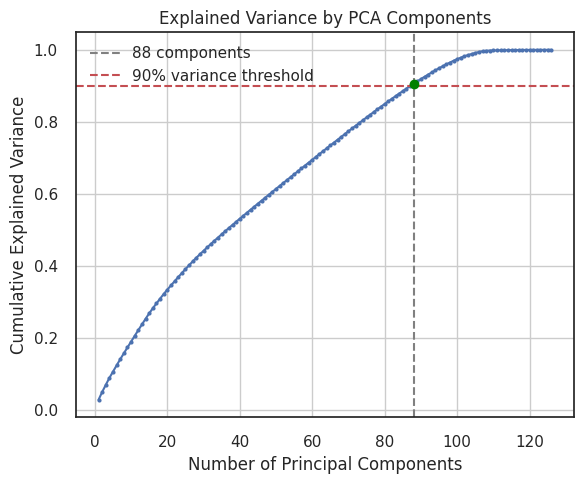

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_onehot)
X_val_scaled = scaler.transform(X_val_onehot)

# Step 2: Fit PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Step 3: Plot explained variance
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
num_components = np.argmax(cum_explained_var >= 0.9) + 1  # +1 for 1-based indexing

plt.figure(figsize=(6, 5))
plt.plot(range(1, len(explained_var) + 1), cum_explained_var, marker='o', markersize = 3)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)

plt.axvline(x=num_components, color='gray', linestyle='--', label=f'{num_components} components')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance threshold')
plt.scatter(num_components, cum_explained_var[num_components - 1], color='green', zorder=5)

plt.legend()
plt.tight_layout()
plt.show()



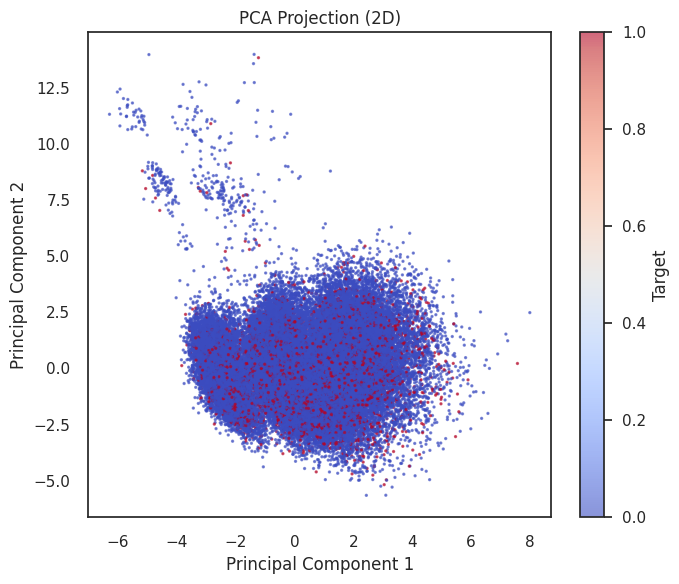

In [ ]:
plt.figure(figsize=(7, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_onehot, cmap='coolwarm', alpha=0.6, s = 2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.colorbar(label='Target')
plt.tight_layout()
plt.show()

In [ ]:
# Slice the top principal components
X_train_pca = X_train_pca[:, :num_components]
X_val_pca = X_val_pca[:, :num_components]

# Train logistic regression on PCA-reduced data using your function
log_reg_pca, log_reg_pca_metrics = train_log_reg(
    X_train_pca, y_train_onehot,
    X_val_pca, y_val_onehot,
    evaluate_model=evaluate_model,
    model_name=f"Logistic Regression, (One Hot, Downsampled, PCA={num_components})"
)

log_reg_pca_metrics

{'Model': 'Logistic Regression, (One Hot, Downsampled, PCA=88)',
 'Accuracy': 0.6815262796932477,
 'Precision': 0.17883495145631068,
 'Sensitivity': 0.5116666666666667,
 'Specificity': 0.7029988060959337,
 'F1 Score': 0.2650359712230216,
 'AUROC': 0.6494927468377149,
 'AUPRC': 0.2088462170274142,
 'Threshold': 0.117508024273282}

# Model Selection

Use dataset that is one-hot encoded, downsampled, cramer-selected, and reduced skewness.

## First test PyCaret

In [ ]:
from pycaret.classification import *

In [ ]:
# # dataset with one-hot encoding
# X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
# X_val_pca_df = pd.DataFrame(X_val_pca, columns=[f'PC{i+1}' for i in range(X_val_pca.shape[1])])

from imblearn.under_sampling import RandomUnderSampler


# Combine training and validation sets
X_trainval_combined = pd.concat([X_train_onehot, X_val_onehot])
y_trainval_combined = pd.concat([y_train_onehot, y_val_onehot])

# Recombine into a single DataFrame
trainval_df_pca = X_trainval_combined.copy()
trainval_df_pca['readmitted'] = y_trainval_combined

clf_setup = setup(
    data=trainval_df_pca,
    target='readmitted',
    session_id=42,
    preprocess=False,
    fix_imbalance=True,
    fix_imbalance_method=RandomUnderSampler()
    # fix_imbalance=True,
    # normalize=True,
)

best_model = compare_models()


,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(80192, 127)"
4,Transformed data shape,"(80192, 127)"
5,Transformed train set shape,"(56134, 127)"
6,Transformed test set shape,"(24058, 127)"
7,Numeric features,126


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8879,0.6621,0.0073,0.5238,0.0144,0.0114,0.0504,0.2320
rf,Random Forest Classifier,0.8878,0.6402,0.0048,0.4292,0.0094,0.0073,0.0362,11.4510
dummy,Dummy Classifier,0.8878,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1090
gbc,Gradient Boosting Classifier,0.8877,0.6708,0.0086,0.4778,0.0168,0.0129,0.0509,12.6930
lightgbm,Light Gradient Boosting Machine,0.8877,0.6681,0.0121,0.4857,0.0235,0.0181,0.0619,5.1500
lr,Logistic Regression,0.8874,0.6607,0.0163,0.4514,0.0315,0.0239,0.0683,13.8330
ada,Ada Boost Classifier,0.8873,0.6636,0.0105,0.4383,0.0204,0.0151,0.0526,3.1160
et,Extra Trees Classifier,0.8868,0.6248,0.0116,0.3551,0.0224,0.0156,0.0466,17.4240
xgboost,Extreme Gradient Boosting,0.8864,0.6503,0.0270,0.4118,0.0506,0.0372,0.0813,1.7510
lda,Linear Discriminant Analysis,0.8847,0.6619,0.0432,0.3813,0.0774,0.0559,0.0964,1.7010


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

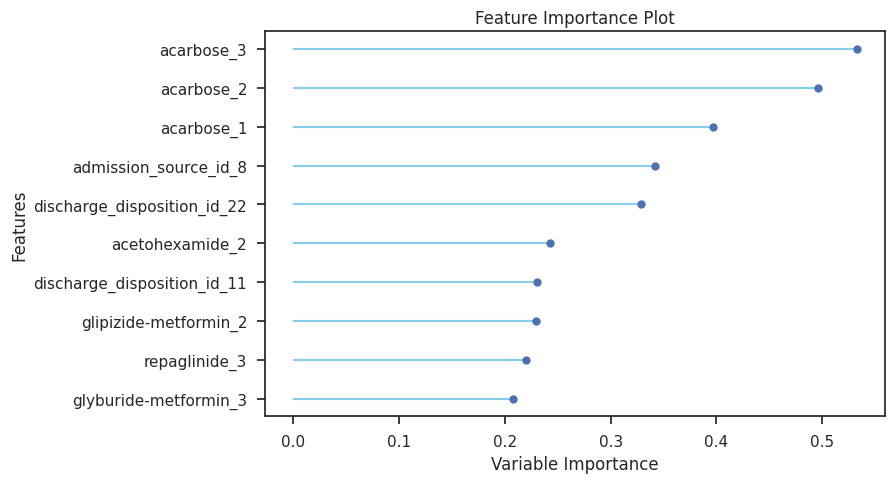

In [ ]:
plot_model(best_model, plot = 'feature')

## Model 1. Logistic Regression with CV

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

def train_log_reg_with_cv_threshold(X_train, y_train, X_val, y_val, evaluate_model, class_weight='None', model_name="LogReg (L2 + Grid + CV Threshold)", cv=5):
    # Step 1: Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', random_state=42))
    ])

    # Step 2: Define grid search for C and class_weight
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__class_weight': [class_weight]
    }

    # Step 3: Grid search
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',  # Grid search still optimizes F1 (optional to change)
        cv=skf,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 4: Out-of-fold predictions for threshold tuning
    y_prob_cv = cross_val_predict(best_model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

    # Step 5: Find threshold via Youden's J
    fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)
    youden_j = tpr - fpr
    best_idx = youden_j.argmax()
    optimal_threshold = thresholds[best_idx]

    # Step 6: Refit on full training set
    best_model.fit(X_train, y_train)

    # Step 7: Predict and evaluate on validation set
    y_val_prob = best_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_prob >= optimal_threshold).astype(int)

    evaluation_results = evaluate_model(y_val, y_val_pred, y_val_prob, model_name)
    evaluation_results['Threshold'] = optimal_threshold
    evaluation_results['Best Params'] = grid_search.best_params_

    return best_model, evaluation_results


In [ ]:
# Step 3: Train logistic regression on downsampled, unskewed data, with cross validation
best_log_reg_cv, log_reg_cv_metrics = train_log_reg_with_cv_threshold(
    X_train_onehot,
    y_train_onehot,
    X_val_onehot,
    y_val_onehot,
    evaluate_model,
    class_weight='balanced',
    model_name="Logistic Regression, One Hot, class-weight balanced, Cross Validated"
)

log_reg_cv_metrics

{'Model': 'Logistic Regression, One Hot, class-weight balanced, Cross Validated',
 'Accuracy': 0.6393166656275329,
 'Precision': 0.16984258492129245,
 'Sensitivity': 0.5694444444444444,
 'Specificity': 0.64814944869724,
 'F1 Score': 0.2616464582003829,
 'AUROC': 0.6552401854062785,
 'AUPRC': 0.21367057456858513,
 'Threshold': 0.4868386545686332,
 'Best Params': {'clf__C': 0.01, 'clf__class_weight': 'balanced'}}

In [ ]:
# Downsample the training set
X_train_onehot_down, y_train_onehot_down = downsample(X_train_onehot, y_train_onehot)

# Step 3: Train logistic regression on downsampled, unskewed data, with cross validation
best_log_reg_cv, log_reg_cv_metrics = train_log_reg_with_cv_threshold(
    X_train_onehot_down,
    y_train_onehot_down,
    X_val_onehot,
    y_val_onehot,
    evaluate_model,
    class_weight=None,
    model_name="Logistic Regression, One Hot, Downsampled, Cross Validated"
)

log_reg_cv_metrics

{'Model': 'Logistic Regression, One Hot, Downsampled, Cross Validated',
 'Accuracy': 0.6563376769125258,
 'Precision': 0.17404285212504392,
 'Sensitivity': 0.5505555555555556,
 'Specificity': 0.6697099515415409,
 'F1 Score': 0.26447824926607955,
 'AUROC': 0.6505063557834118,
 'AUPRC': 0.20979797094465927,
 'Threshold': 0.4987035878902272,
 'Best Params': {'clf__C': 0.1, 'clf__class_weight': None}}

## Model 2. Random Forest

In [ ]:
def train_random_forest(X_train, y_train, X_val, y_val, evaluate_model, model_name="Random Forest"):
    """
    Function to train Random Forest with GridSearchCV, finds optimal threshold
    and evaluates the model performance, feature importance

    Returns:
        best random forest model, optimal_threshold (float), evaluation_results, feature importance ranking
    """

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [20],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    }

    rf = RandomForestClassifier(random_state=42, class_weight=None)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        verbose=0,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # Predict probabilities with the best random forest model
    y_prob = best_rf.predict_proba(X_val)[:, 1]

    # Find optimal threshold using ROC curve (Youden’s J)
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    optimal_threshold = thresholds[best_index]

    # Apply threshold and get predictions
    y_pred = (y_prob >= optimal_threshold).astype(int)

    # Evaluate model
    evaluation_results = evaluate_model(y_val, y_pred, y_prob, model_name)
    evaluation_results['Threshold'] = optimal_threshold
    evaluation_results['Best Params'] = grid_search.best_params_

    # Generate feature importance
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_rf.feature_importances_
    }).set_index("Feature")

    return best_rf, optimal_threshold, evaluation_results, importance_df

In [ ]:
# Step 1: Split the unskewed, Cramér-selected one-hot dataset
# X_train_onehot, X_val_onehot, X_test_onehot_cramer_unskewed, y_train_onehot_cramer_unskewed, y_val_onehot_cramer_unskewed, y_test_onehot_cramer_unskewed = split_data(diabetic_df_onehot_cramer_unskewed)

# Step 2: Downsample the training set
# X_train_onehot_cramer_unskewed_down, y_train_onehot_cramer_unskewed_down = downsample(X_train_onehot_cramer_unskewed, y_train_onehot_cramer_unskewed)

# Step 3: Train Random Forest on downsampled, unskewed, Cramér-selected one-hot dataset
best_rf_model, optimal_rf_threshold, rf_eval_results, rf_feature_importance = train_random_forest(
    X_train_onehot,
    y_train_onehot,
    X_val_onehot,
    y_val_onehot,
    evaluate_model,
    model_name="Random Forest, One Hot, Unskewed, Downsampled, Cramer"
)


KeyboardInterrupt: 

In [ ]:
rf_eval_results

{'Model': 'Random Forest, One Hot, Unskewed, Downsampled, Cramer',
 'Accuracy': 0.6159985036473595,
 'Precision': 0.1688193283695487,
 'Sensitivity': 0.6172222222222222,
 'Specificity': 0.615843809256268,
 'F1 Score': 0.26512349361651355,
 'AUROC': 0.6590635266209394,
 'AUPRC': 0.2090777544291609,
 'Threshold': 0.49481276017876397,
 'Best Params': {'bootstrap': True,
  'max_depth': 20,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 200}}

<Figure size 1200x600 with 0 Axes>

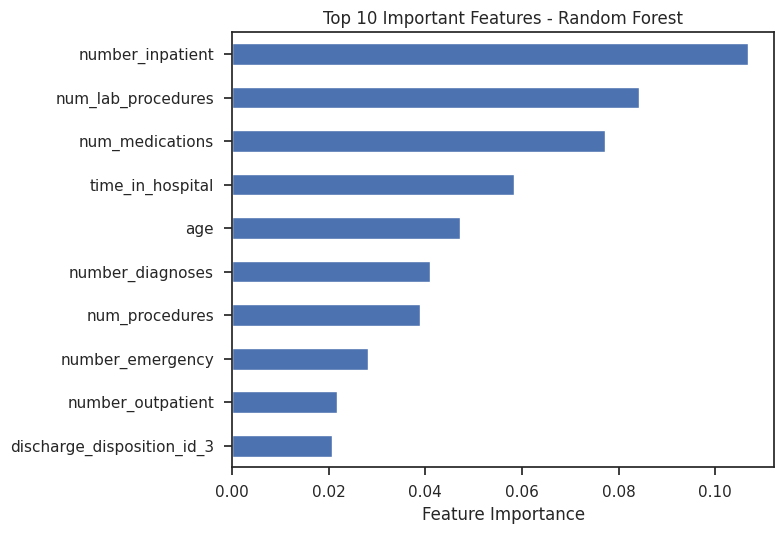

In [ ]:

# Sort and select top 10 most important features
top_n = 10
rf_feature_importance_sorted = rf_feature_importance.sort_values(by='Importance', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(12, 6))
rf_feature_importance_sorted.plot(kind='barh', legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('')

plt.title(f'Top {top_n} Important Features - Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


## Model 3. XGBoost

In [ ]:
def train_xgboost_model(X_train, y_train, X_val, y_val, evaluate_model, model_name="XGBoost"):
    """
    Function to train XGBoost with hyperparameter tuning with GridSearchCV,
    finds optimal threshold using ROC (Youden's J), evaluates performances

    Returns:
        best_model (fitted XGBClassifier), optimal_threshold (float), evaluation_results (dict)
    """

    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0]
    }


    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
    )

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        verbose=0,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_

    y_prob = best_xgb.predict_proba(X_val)[:, 1]

    thresholds = np.linspace(0.01, 0.99, 100)
    f1_scores = [f1_score(y_val, (y_prob >= t).astype(int)) for t in thresholds]
    best_index = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_index]


    # Predict using optimal threshold
    y_pred = (y_prob >= optimal_threshold).astype(int)

    # Evaluate model
    evaluation_results = evaluate_model(y_val, y_pred, y_prob, model_name)
    evaluation_results['Threshold'] = optimal_threshold
    evaluation_results['Best Params'] = grid_search.best_params_

    # Generate feature importance
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_xgb.feature_importances_
    }).set_index("Feature")

    return best_xgb, evaluation_results, importance_df

In [ ]:
# Step 1: Split the unskewed, Cramér-selected one-hot downsampled dataset
X_train_onehot_cramer_unskewed, X_val_onehot_cramer_unskewed, X_test_onehot_cramer_unskewed, y_train_onehot_cramer_unskewed, y_val_onehot_cramer_unskewed, y_test_onehot_cramer_unskewed = split_data(diabetic_df_onehot_cramer_unskewed)

# Step 2: Downsample the training set
X_train_onehot_cramer_unskewed_down, y_train_onehot_cramer_unskewed_down = downsample(X_train_onehot_cramer_unskewed, y_train_onehot_cramer_unskewed)


# Train XGBoost model with full filtered dataset
best_xgb, xgb_metrics, importance_df_XGB = train_xgboost_model(
    X_train_onehot_cramer_unskewed_down,
    y_train_onehot_cramer_unskewed_down,
    X_val_onehot_cramer_unskewed,
    y_val_onehot_cramer_unskewed,
    evaluate_model, model_name="XGBoost, One Hot, Unskewed, Downsampled, Cramer"
)

xgb_metrics

{'Model': 'XGBoost, One Hot, Unskewed, Downsampled, Cramer',
 'Accuracy': 0.7714944821996383,
 'Precision': 0.20904836193447737,
 'Sensitivity': 0.37222222222222223,
 'Specificity': 0.8219678348198609,
 'F1 Score': 0.2677322677322677,
 'AUROC': 0.6548358381908842,
 'AUPRC': 0.19951153765857557,
 'Threshold': 0.5346464646464646,
 'Best Params': {'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 100,
  'subsample': 1.0}}

<Figure size 1200x600 with 0 Axes>

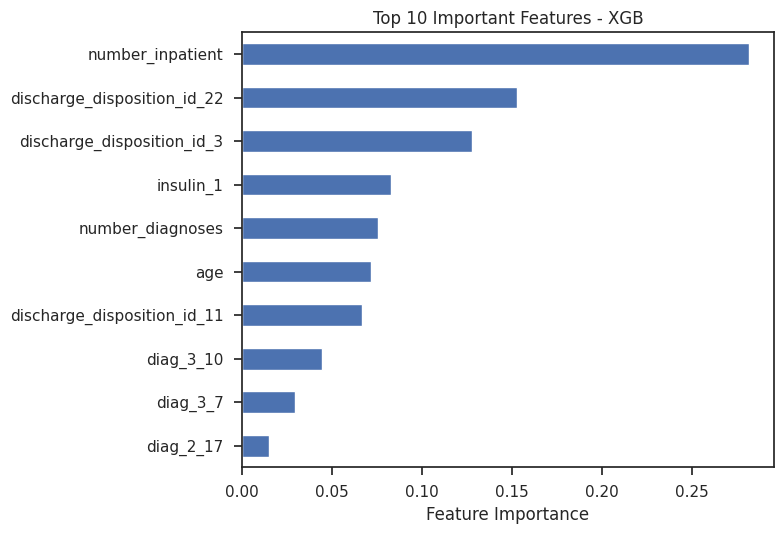

In [ ]:
# Sort and select top 20 most important features
top_n = 10
importance_df_XGB_sorted = importance_df_XGB.sort_values(by='Importance', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(12, 6))
importance_df_XGB_sorted.plot(kind='barh', legend=False)
plt.xlabel('Feature Importance')
plt.ylabel('')

plt.title(f'Top {top_n} Important Features - XGB')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

## Model 4. MLP
Use the MLP model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import numpy as np

def train_mlp(X_train, y_train, X_val, y_val, evaluate_model_fn, model_name="MLP + GridSearch"):
    """
    Trains an MLP model with GridSearchCV and evaluates on validation set.
    """

    # Step 1: Define pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(max_iter=500, early_stopping=True, random_state=42))
    ])

    # Step 2: Define parameter grid to search
    param_grid = {
        'clf__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'clf__alpha': [0.0001, 0.001, 0.01],  # L2 regularization strength
        'clf__learning_rate_init': [0.001, 0.01],
    }

    # Step 3: Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Step 4: Predict on validation set
    y_val_prob = best_model.predict_proba(X_val)[:, 1]

    # Find threshold via Youden's J (you can switch to F1 if desired)
    fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    optimal_threshold = thresholds[best_index]

    # Final predictions
    y_val_pred = (y_val_prob >= optimal_threshold).astype(int)

    # Step 5: Evaluate
    evaluation_results = evaluate_model_fn(y_val, y_val_pred, y_val_prob, model_name)
    evaluation_results['Threshold'] = optimal_threshold
    evaluation_results['Best Params'] = grid_search.best_params_

    return best_model, evaluation_results



In [ ]:
# With original (balanced class_weight isn't available for MLP)
best_mlp, mlp_metrics = train_mlp(
    X_train_onehot_cramer_unskewed_down,
    y_train_onehot_cramer_unskewed_down,
    X_val_onehot_cramer_unskewed,
    y_val_onehot_cramer_unskewed,
    evaluate_model, model_name="MLP , One Hot, Unskewed, Downsampled, Cramer"
)

mlp_metrics


Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'Model': 'MLP , One Hot, Unskewed, Downsampled, Cramer',
 'Accuracy': 0.6457385123760833,
 'Precision': 0.17023445463812437,
 'Sensitivity': 0.5566666666666666,
 'Specificity': 0.656998384718028,
 'F1 Score': 0.2607338017174083,
 'AUROC': 0.647377546800259,
 'AUPRC': 0.20067678144004075,
 'Threshold': 0.527682889447608,
 'Best Params': {'clf__alpha': 0.001,
  'clf__hidden_layer_sizes': (50,),
  'clf__learning_rate_init': 0.01}}

## Model Evaluation & Metrics Visualization

In [ ]:
# combine all evaluation results for comparison
evaluation_results_all = pd.DataFrame([
    log_reg_cv_metrics,
    rf_eval_results,
    xgb_metrics,
    mlp_metrics,
])

# Keep only part before the first comma in model names
evaluation_results_all['Model'] = evaluation_results_all['Model'].str.split(',').str[0]

evaluation_results_all = evaluation_results_all.set_index('Model')
evaluation_results_all.sort_values(by='F1 Score', ascending=False, inplace=True)
evaluation_results_all

,Accuracy,Precision,Sensitivity,Specificity,F1 Score,AUROC,AUPRC,Threshold,Best Params
Model,,,,,,,,,
Logistic Regression,0.724422,0.191765,0.452778,0.758761,0.269421,0.654897,0.204632,0.130000,"{'clf__C': 1, 'clf__class_weight': None}"
XGBoost,0.771494,0.209048,0.372222,0.821968,0.267732,0.654836,0.199512,0.534646,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
Random Forest,0.615999,0.168819,0.617222,0.615844,0.265123,0.659064,0.209078,0.494813,"{'bootstrap': True, 'max_depth': 20, 'min_samp..."
MLP,0.645739,0.170234,0.556667,0.656998,0.260734,0.647378,0.200677,0.527683,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."


In [ ]:
# combine all evaluation results for comparison
evaluation_results_all = pd.DataFrame([
    log_reg_cv_metrics,
    rf_eval_results,
    xgb_metrics,
    mlp_metrics,
])

# Keep only part before the first comma in model names
evaluation_results_all['Model'] = evaluation_results_all['Model'].str.split(',').str[0]

evaluation_results_all = evaluation_results_all.set_index('Model')
evaluation_results_all.sort_values(by='F1 Score', ascending=False, inplace=True)
evaluation_results_all

,Accuracy,Precision,Sensitivity,Specificity,F1 Score,AUROC,AUPRC,Threshold,Best Params
Model,,,,,,,,,
Random Forest,0.640377,0.174113,0.588889,0.646885,0.268763,0.658239,0.206954,0.502014,NaN
XGBoost,0.771744,0.209310,0.372222,0.822249,0.267946,0.654784,0.205106,0.534646,NaN
Logistic Regression,0.631149,0.169344,0.585556,0.636913,0.262712,0.652284,0.200075,0.488749,NaN
MLP,0.645739,0.170234,0.556667,0.656998,0.260734,0.647378,0.200677,0.527683,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."


In [ ]:
def plot_metrics(metrics_df, metrics_to_plot=None, models_to_plot= None):

    if metrics_to_plot is None:
        metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score']

    df_plot = metrics_df.reset_index()


    if models_to_plot is not None:
        df_plot = df_plot[df_plot['Model'].isin(models_to_plot)]

    df_melt = df_plot.melt(id_vars="Model", value_vars=metrics_to_plot,
                           var_name="Metric", value_name="Score")

    sns.set(style="white")


    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model")
    plt.title("Performance Metrics by Models", fontsize=15)
    plt.xlabel(" ", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0, fontsize = 12)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_metrics(evaluation_results_all, metrics_to_plot=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'],
             models_to_plot = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP'])


plot_metrics(evaluation_results_all, metrics_to_plot=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'],
             models_to_plot = ['Logistic Regression', 'Logistic Regression_downsampled', 'Logistic Regression_upsampled'])

# random forest
plot_metrics(evaluation_results_all, metrics_to_plot=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'],
             models_to_plot = ['Random Forest', 'Random Forest_Downsampled', 'Random Forest_Upsampled'])
# xgboost
plot_metrics(evaluation_results_all, metrics_to_plot=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1 Score'],
             models_to_plot = ['XGBoost', 'XGBoost_Downsampled', 'XGBoost_Upsampled'])

Thus, we selected XGBoost for now to be our best model

In [ ]:
import pandas as pd

data = {
    "Feature": [
        "Gender",
        "Age",
        "Admission Type",
        "Admission Source",
        "Discharge Disposition",
        "Diagnosis 1/2/3",
        "Medication Information",
        "Change of Medication",
        "Outcome Variable (Target)"
    ],
    "Original Format": [
        "F, M",
        "Age groups (every 10 years)",
        "8 categories",
        "26 categories",
        "29 categories",
        "> 800 unique ICD-9 codes",
        "‘No’, ‘Steady’, ‘Up’, ‘Down’",
        "Change (steady/up/down); No",
        "No; Readmission >30 days; Readmission <30 days"
    ],
    "Encoding": [
        "F: 1; M: 0",
        "[0-10]: 0; [10-20]: 1; [20-30]: 2; [30-40]: 3; [40-50]: 4; [50-60]: 5; [60-70]: 6; [70-80]: 7; [80-90]: 8; [90-100]: 9",
        "Null/Not mapped/Not available: 0; Emergency/Urgent: 1; Elective: 2; Newborn: 3; Trauma Center: 4",
        "Unknown/Invalid: 0; Physician/Clinic Referral: 1; Transfer from Hospital: 2; Transfer from Facility: 3; Delivery: 4; Emergency: 5; Court/Law Enforcement: 6",
        "Home: 0; Uncategorized/Unknown: 1; Expired: 2; Hospice: 3; Hospital: 4; Rehab Facility: 5; Care Facility: 6; Outpatient Services: 7; Left AMA: 8",
        "Grouped into 18 categories based on ICD-9 codes (linked)",
        "No (Not given): 0; Prescribed (Steady/Up/Down): 1",
        "No: 0; Change: 1",
        "No & Readmission >30 days: 0; Readmission <30 days: 1"
    ]
}

df = pd.DataFrame(data)
df.to_excel("feature_encoding_table.xlsx", index=False)


In [ ]:
from google.colab import files
files.download('feature_encoding_table.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

data = {
    "Feature": [
        "Gender",
        "Age",
        "Admission Type",
        "Admission Source",
        "Discharge Disposition",
        "Diagnosis 1/2/3",
        "Medication Information",
        "Change of Medication",
        "Outcome Variable (Target)"
    ],
    "Original Format": [
        "F, M",
        "Age groups (every 10 years)",
        "8 categories",
        "26 categories",
        "29 categories",
        "> 800 unique ICD-9 codes",
        "‘No’, ‘Steady’, ‘Up’, ‘Down’",
        "Change (steady/up/down); No",
        "No; Readmission >30 days; Readmission <30 days"
    ],
    "Encoding": [
        "F: 1; M: 0",
        "[0-10]: 0; [10-20]: 1; ... [90-100]: 9",
        "Null/Not mapped/Not available: 0; Emergency/Urgent: 1; ... Trauma Center: 4",
        "Unknown/Invalid: 0; Physician/Clinic Referral: 1; ... Court/Law Enforcement: 6",
        "Home: 0; Uncategorized/Unknown: 1; ... Left AMA: 8",
        "Grouped into 18 categories based on ICD-9 codes (linked)",
        "No (Not given): 0; Prescribed (Steady/Up/Down): 1",
        "No: 0; Change: 1",
        "No & Readmission >30 days: 0; Readmission <30 days: 1"
    ],
    "One-Hot Encoded Columns": [
        "gender_0, gender_1",
        "age_0, age_1, ..., age_9",
        "admission_type_id_0, admission_type_id_1, ..., admission_type_id_4",
        "admission_source_id_0, admission_source_id_1, ..., admission_source_id_6",
        "discharge_disposition_id_0, discharge_disposition_id_1, ..., discharge_disposition_id_8",
        "diag_1_0, diag_1_1, ..., diag_1_17; diag_2_0, ..., diag_2_17; diag_3_0, ..., diag_3_17",
        "medication_column_0, medication_column_1",  # Replace with actual column names if you have them!
        "change_0, change_1",
        "readmitted"
    ]
}

df = pd.DataFrame(data)

# Save to Excel
df.to_excel("feature_encoding_table_actual_onehot.xlsx", index=False)

# For Colab, download
from google.colab import files
files.download('feature_encoding_table_actual_onehot.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Feature Selection
We selected the top 10 features based on feature importance from XGB model training.

In [ ]:
top_feature_xgb = importance_df_XGB.sort_values(by='Importance', ascending=False).head(12)
top_feature_names = top_feature_xgb.index.tolist()

X_train_top = X_train[top_feature_names]
X_val_top = X_val[top_feature_names]

best_xgb_top, eval_results_top, importance_top = train_xgboost_model(
    X_train_top, y_train,
    X_val_top, y_val,
    evaluate_model,
    model_name="XGBoost_Top15"
)

In [ ]:
eval_results_top

{'Model': 'XGBoost_Top15',
 'Accuracy': 0.6709271151568053,
 'Precision': 0.17700594353640417,
 'Sensitivity': 0.5294444444444445,
 'Specificity': np.float64(0.6888124166022895),
 'F1 Score': 0.2653118040089087,
 'AUROC': np.float64(0.6539842256400653),
 'AUPRC': np.float64(0.21078797163095375),
 'Threshold': np.float32(0.51217777)}

# MINI SUBSET

In [ ]:
# Remove the variables that contains the same values - so they do not provide useful discriminatory information
diabetic_df_filtered = diabetic_df.drop(['citoglipton', 'examide'], axis = 1)

# encounter_id and patient_nbr do not carry useful information for re-admission, so we drop them as well
diabetic_df_filtered = diabetic_df_filtered.drop(['encounter_id', 'patient_nbr'], axis = 1)

# For computation, we drop the rest columns with lots of missing values - race, diag_1, diag_2, diag_3
diabetic_df_filtered = diabetic_df_filtered.drop(['race', 'diag_1', 'diag_2', 'diag_3'], axis = 1)

# drop columns payer code and medical speciality
diabetic_df_filtered = diabetic_df_filtered.drop(columns=['payer_code', 'medical_specialty']).copy()

diabetic_df_filtered['readmitted'] = [1 if x == readmit else 0 for x in diabetic_df_filtered['readmitted']]


In [ ]:
# TODO: SUPPLEMENTARY TO SHOW skewed race data

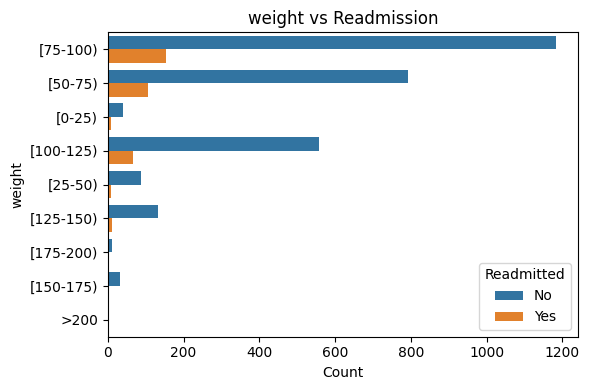

In [ ]:
# remove the samples with missing Gender and weight
diabetic_df_filtered_withWeight = diabetic_df_filtered.dropna(subset=['gender', 'weight'])
diabetic_df_filtered_withWeight = diabetic_df_filtered_withWeight.drop(['max_glu_serum', 'A1Cresult'], axis = 1, errors = 'ignore')

diabetic_df_filtered_withWeight.shape

plt.figure(figsize=(6, 4))
sns.countplot(y=diabetic_df_filtered_withWeight['weight'], hue=diabetic_df_filtered_withWeight['readmitted'])
plt.title(f'weight vs Readmission')
plt.xlabel('Count')
plt.ylabel('weight')
plt.legend(title='Readmitted', labels=['No', 'Yes'], loc = 'lower right')
plt.tight_layout()
plt.show()

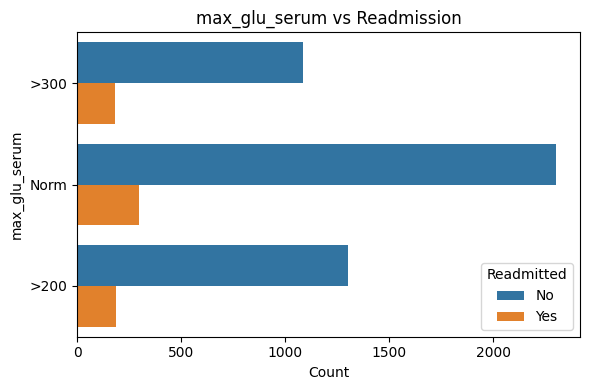

In [ ]:
# remove the samples with missing Gender and diabetes markers
diabetic_df_filtered_withMaxGlu = diabetic_df_filtered.dropna(subset=['gender', 'max_glu_serum'])
diabetic_df_filtered_withMaxGlu = diabetic_df_filtered_withMaxGlu.drop(columns=['weight', 'A1Cresult'], errors='ignore')
diabetic_df_filtered_withMaxGlu.shape

plt.figure(figsize=(6, 4))
sns.countplot(y=diabetic_df_filtered_withMaxGlu['max_glu_serum'], hue=diabetic_df_filtered_withMaxGlu['readmitted'])
plt.title(f'max_glu_serum vs Readmission')
plt.xlabel('Count')
plt.ylabel('max_glu_serum')
plt.legend(title='Readmitted', labels=['No', 'Yes'], loc = 'lower right')
plt.tight_layout()
plt.show()

In [ ]:
diabetic_df_filtered_withMaxGlu['max_glu_serum'].unique()

array(['>300', 'Norm', '>200'], dtype=object)

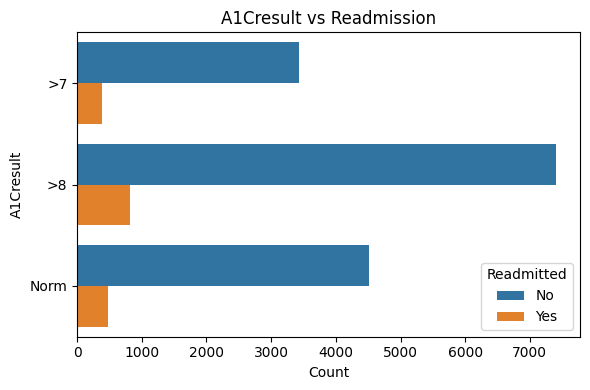

In [ ]:
# remove the samples with missing Gender and diabetes markers
diabetic_df_filtered_withA1C = diabetic_df_filtered.dropna(subset=['gender', 'A1Cresult'])
diabetic_df_filtered_withA1C = diabetic_df_filtered_withA1C.drop(columns = ['weight', 'max_glu_serum'], errors='ignore')
diabetic_df_filtered_withA1C.shape

plt.figure(figsize=(6, 4))
sns.countplot(y=diabetic_df_filtered_withA1C['A1Cresult'], hue=diabetic_df_filtered_withA1C['readmitted'])
plt.title(f'A1Cresult vs Readmission')
plt.xlabel('Count')
plt.ylabel('A1Cresult')
plt.legend(title='Readmitted', labels=['No', 'Yes'], loc = 'lower right')
plt.tight_layout()
plt.show()

In [ ]:
diabetic_df_filtered_withA1C['A1Cresult'].unique()

array(['>7', '>8', 'Norm'], dtype=object)

## Feature Engineering



#### Feature Encoding

Here we performed encoding for categorical variables

In [ ]:
def preprocess_subset(df):
    df_encoded = df.copy()

    # Encode readmission
    df_encoded['readmitted'] = [1 if x == readmit else 0 for x in df['readmitted']]

    # Encode gender
    df_encoded['gender'] = df_encoded['gender'].map({'Female': 1, 'Male': 0})

    # Encode age
    age_mapping = {
        '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
        '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
    }
    df_encoded['age'] = df_encoded['age'].map(age_mapping)

    # Encode weight if exists
    if 'weight' in df_encoded.columns:
        weight_mapping = {
            '[0-25)': 0, '[25-50)': 1, '[50-75)': 2, '[75-100)': 3,
            '[100-125)': 4, '[125-150)': 5, '[150-175)': 6, '[175-200)': 7, '>200': 8
        }
        df_encoded['weight'] = df_encoded['weight'].map(weight_mapping)

    # Encode medications
    medication_columns = [
        "metformin", "repaglinide", "nateglinide", "chlorpropamide",
        "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
        "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
        "insulin", "glyburide-metformin", "glipizide-metformin",
        "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
    ]
    for col in medication_columns:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(lambda x: 0 if x == 'No' else 1)

    # Encode max_glu_serum
    if 'max_glu_serum' in df_encoded.columns:
        df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map({'Norm': 0, '>200': 1, '>300': 2})

    # Encode A1Cresult
    if 'A1Cresult' in df_encoded.columns:
        df_encoded['A1Cresult'] = df_encoded['A1Cresult'].map({'Norm': 0, '>7': 1, '>8': 2})

    # Encode change and diabetesMed
    df_encoded['change'] = df_encoded['change'].map({'Ch': 1, 'No': 0})
    df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map({'Yes': 1, 'No': 0})

    return df_encoded


#### Visualizing data imbalance


In [ ]:
readmit = diabetic_df_filtered['readmitted'][11]

def plot_class_distribution(df, subset_name):

    plt.figure(figsize=(4, 4))
    ax = sns.countplot(x=df['readmitted'])

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

    plt.title(f"Readmission Distribution ({subset_name})")
    plt.xlabel("Readmitted within 30 Days (1 = Yes, 0 = No)")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["No", "Yes"])
    plt.tight_layout()
    plt.show()


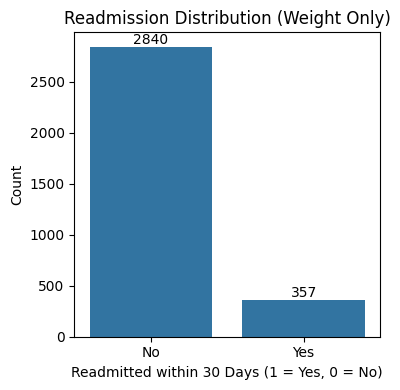

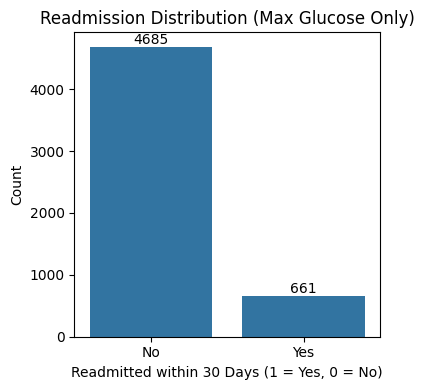

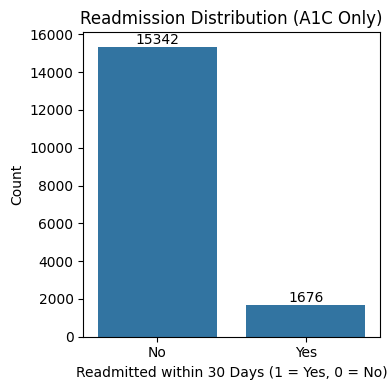

In [ ]:
subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "A1C Only": diabetic_df_filtered_withA1C
}

for name, df in subsets.items():
    # print(f"\n🧪 Processing subset: {name}")
    df = preprocess_subset(df)
    plot_class_distribution(df, name)       # visualize class imbalance



### Feature selection

### Feature subsetting

In [ ]:
from sklearn.utils import resample

def downsample_df(df):
    df_majority = df[df['readmitted'] == 0]
    df_minority = df[df['readmitted'] == 1]

    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_downsampled


## Model Selection

In [ ]:
# define a funtion for model evaluation
def evaluate_model(y_true, y_pred, y_prob, name):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prc = average_precision_score(y_true, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "Model": name,
        "Accuracy": acc,
        "Sensitivity": rec,
        "Specificity": specificity,
        "F1 Score": f1,
        "AUROC": auc,
        "AUPRC": prc
    }


### Model 1. Logistic Regression as Baseline Model

In [ ]:
def run_logistic_regression(df_encoded, model_name):
    X = df_encoded.drop(columns=['readmitted'])
    y = df_encoded['readmitted']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    log_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])
    log_reg.fit(X_train, y_train)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    best_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[best_index]

    y_pred = (y_prob >= optimal_threshold).astype(int)

    print(f"{model_name} — Optimal Threshold: {optimal_threshold:.4f}")
    return evaluate_model(y_test, y_pred, y_prob, model_name)


#### Original

In [ ]:
subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "A1C Only": diabetic_df_filtered_withA1C
}

results = []

for name, df in subsets.items():
    print(f"\n🔍 Processing Subset: {name}")

    df_encoded = preprocess_subset(df)

    result = run_logistic_regression(df_encoded, f"LogReg ({name})")

    # df_downsampled = downsample_df(df_encoded)
    # result = run_logistic_regression(df_downsampled, f"LogReg ({name})")

    print('LogReg Results:\n', result)


🔍 Processing Subset: Weight Only
LogReg (Weight Only) — Optimal Threshold: 0.5823
LogReg Results:
 {'Model': 'LogReg (Weight Only)', 'Accuracy': 0.81875, 'Sensitivity': 0.3380281690140845, 'Specificity': np.float64(0.8787346221441125), 'F1 Score': 0.2926829268292683, 'AUROC': np.float64(0.6129112106735315), 'AUPRC': np.float64(0.22480303988072012)}

🔍 Processing Subset: Max Glucose Only
LogReg (Max Glucose Only) — Optimal Threshold: 0.6085
LogReg Results:
 {'Model': 'LogReg (Max Glucose Only)', 'Accuracy': 0.8084112149532711, 'Sensitivity': 0.3181818181818182, 'Specificity': np.float64(0.8773987206823027), 'F1 Score': 0.2906574394463668, 'AUROC': np.float64(0.6121502875234219), 'AUPRC': np.float64(0.20795319007889917)}

🔍 Processing Subset: A1C Only
LogReg (A1C Only) — Optimal Threshold: 0.4633
LogReg Results:
 {'Model': 'LogReg (A1C Only)', 'Accuracy': 0.52262044653349, 'Sensitivity': 0.7044776119402985, 'Specificity': np.float64(0.5027696318018898), 'F1 Score': 0.22508345255126372, 

#### Downsampled

In [ ]:
subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "A1C Only": diabetic_df_filtered_withA1C
}

results = []

for name, df in subsets.items():
    print(f"\n🔍 Processing Subset: {name}")

    df_encoded = preprocess_subset(df)

    # result = run_logistic_regression(df_encoded, f"LogReg ({name})")

    df_downsampled = downsample_df(df_encoded)
    result = run_logistic_regression(df_downsampled, f"LogReg ({name})")

    print('Downsampled LogReg Results:\n', result)



🔍 Processing Subset: Weight Only
LogReg (Weight Only) — Optimal Threshold: 0.5930
Downsampled LogReg Results:
 {'Model': 'LogReg (Weight Only)', 'Accuracy': 0.6153846153846154, 'Sensitivity': 0.4084507042253521, 'Specificity': np.float64(0.8194444444444444), 'F1 Score': 0.5132743362831859, 'AUROC': np.float64(0.5919405320813772), 'AUPRC': np.float64(0.6398739747784699)}

🔍 Processing Subset: Max Glucose Only
LogReg (Max Glucose Only) — Optimal Threshold: 0.4061
Downsampled LogReg Results:
 {'Model': 'LogReg (Max Glucose Only)', 'Accuracy': 0.569811320754717, 'Sensitivity': 0.7878787878787878, 'Specificity': np.float64(0.3533834586466165), 'F1 Score': 0.6459627329192547, 'AUROC': np.float64(0.543859649122807), 'AUPRC': np.float64(0.5493134103606041)}

🔍 Processing Subset: A1C Only
LogReg (A1C Only) — Optimal Threshold: 0.4805
Downsampled LogReg Results:
 {'Model': 'LogReg (A1C Only)', 'Accuracy': 0.5692995529061102, 'Sensitivity': 0.591044776119403, 'Specificity': np.float64(0.54761904

### Model 2. Random Forest

In [ ]:
def run_random_forest(df_encoded, model_name, param_grid=None):
    X = df_encoded.drop(columns=['readmitted'])
    y = df_encoded['readmitted']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Define Random Forest with class balancing
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')

    # If param_grid is provided, use GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=5,
            scoring='f1',
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_rf = grid_search.best_estimator_
        print(f"{model_name} — Best RF Parameters: {grid_search.best_params_}")
    else:
        best_rf = rf.fit(X_train, y_train)

    y_prob = best_rf.predict_proba(X_test)[:, 1]

    # Find optimal threshold (Youden’s J statistic)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    best_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[best_index]

    y_pred = (y_prob >= optimal_threshold).astype(int)

    print(f"{model_name} — Optimal Threshold: {optimal_threshold:.4f}")
    results = evaluate_model(y_test, y_pred, y_prob, model_name)

    return results, best_rf



#### Original Data

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# compare model performance with or without features weight/maxglu/A1C
subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "No weight": diabetic_df_filtered_withWeight.drop(columns=['weight']),
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "No maxglu": diabetic_df_filtered_withMaxGlu.drop(columns=['max_glu_serum']),
    "A1C Only": diabetic_df_filtered_withA1C,
    "No A1C": diabetic_df_filtered_withA1C.drop(columns=['A1Cresult'])
}

rf_results = []

for name, df in subsets.items():
    print(f"\n🌲 Processing Subset (Random Forest): {name}")

    df_encoded = preprocess_subset(df)

    # try:
    #     df_downsampled = downsample_df(df_encoded)
    # except ValueError as e:
    #     print(f"⚠️ Skipping {name} — {e}")
    #     continue
    print(df_encoded.shape)
    result = run_random_forest(df_encoded, f"RandomForest ({name})", param_grid)
    # print(result)
    rf_results.append(result)



🌲 Processing Subset (Random Forest): Weight Only
(3197, 38)
RandomForest (Weight Only) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest (Weight Only) — Optimal Threshold: 0.4378

🌲 Processing Subset (Random Forest): No weight
(3197, 37)
RandomForest (No weight) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest (No weight) — Optimal Threshold: 0.4337

🌲 Processing Subset (Random Forest): Max Glucose Only
(5346, 38)
RandomForest (Max Glucose Only) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RandomForest (Max Glucose Only) — Optimal Threshold: 0.4654

🌲 Processing Subset (Random Forest): No maxglu
(5346, 37)
RandomForest (No maxglu) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_sample

In [ ]:
rf_results

[({'Model': 'RandomForest (Weight Only)',
   'Accuracy': 0.79375,
   'Sensitivity': 0.4225352112676056,
   'Specificity': np.float64(0.8400702987697716),
   'F1 Score': 0.3125,
   'AUROC': np.float64(0.6293472610708185),
   'AUPRC': np.float64(0.2610527903265557)},
  RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                         min_samples_split=5, n_estimators=200, random_state=42)),
 ({'Model': 'RandomForest (No weight)',
   'Accuracy': 0.76875,
   'Sensitivity': 0.4647887323943662,
   'Specificity': np.float64(0.8066783831282952),
   'F1 Score': 0.308411214953271,
   'AUROC': np.float64(0.6294462734226095),
   'AUPRC': np.float64(0.2689396864432333)},
  RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                         min_samples_leaf=2, n_estimators=200, random_state=42)),
 ({'Model': 'RandomForest (Max Glucose Only)',
   'Accuracy': 0.7345794392523365,
   'Sensitivity': 0.4015151515151515,
   'Specific

#### Downsampled

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# compare model performance with or without features weight/maxglu/A1C
subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "No weight": diabetic_df_filtered_withWeight.drop(columns=['weight']),
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "No maxglu": diabetic_df_filtered_withMaxGlu.drop(columns=['max_glu_serum']),
    "A1C Only": diabetic_df_filtered_withA1C,
    "No A1C": diabetic_df_filtered_withA1C.drop(columns=['A1Cresult'])
}

rf_downsampled_results = []

for name, df in subsets.items():
    print(f"\n🌲 Processing Subset (Random Forest): {name}")

    df_encoded = preprocess_subset(df)

    df_downsampled = downsample_df(df_encoded)

    result = run_random_forest(df_downsampled, f"RandomForest ({name})", param_grid)
    # print(result)
    rf_downsampled_results.append(result)



🌲 Processing Subset (Random Forest): Weight Only
RandomForest (Weight Only) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RandomForest (Weight Only) — Optimal Threshold: 0.5420

🌲 Processing Subset (Random Forest): No weight
RandomForest (No weight) — Best RF Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest (No weight) — Optimal Threshold: 0.6232

🌲 Processing Subset (Random Forest): Max Glucose Only
RandomForest (Max Glucose Only) — Best RF Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest (Max Glucose Only) — Optimal Threshold: 0.5684

🌲 Processing Subset (Random Forest): No maxglu
RandomForest (No maxglu) — Best RF Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RandomFo

In [ ]:
rf_downsampled_results

[({'Model': 'RandomForest (Weight Only)',
   'Accuracy': 0.6363636363636364,
   'Sensitivity': 0.5070422535211268,
   'Specificity': np.float64(0.7638888888888888),
   'F1 Score': 0.5806451612903226,
   'AUROC': np.float64(0.6246087636932707),
   'AUPRC': np.float64(0.6635615573847243)},
  RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                         min_samples_split=5, random_state=42)),
 ({'Model': 'RandomForest (No weight)',
   'Accuracy': 0.6153846153846154,
   'Sensitivity': 0.28169014084507044,
   'Specificity': np.float64(0.9444444444444444),
   'F1 Score': 0.42105263157894735,
   'AUROC': np.float64(0.6322378716744915),
   'AUPRC': np.float64(0.675900869335365)},
  RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                         min_samples_split=5, n_estimators=200, random_state=42)),
 ({'Model': 'RandomForest (Max Glucose Only)',
   'Accuracy': 0.569811320754717,
   'Sensitivity': 0.431818181818

##### Check feature importance

The features weight, maxglu, and A1C showed relatively high importance.\
weight: rank 8\
maxglu & A1C: rank 12

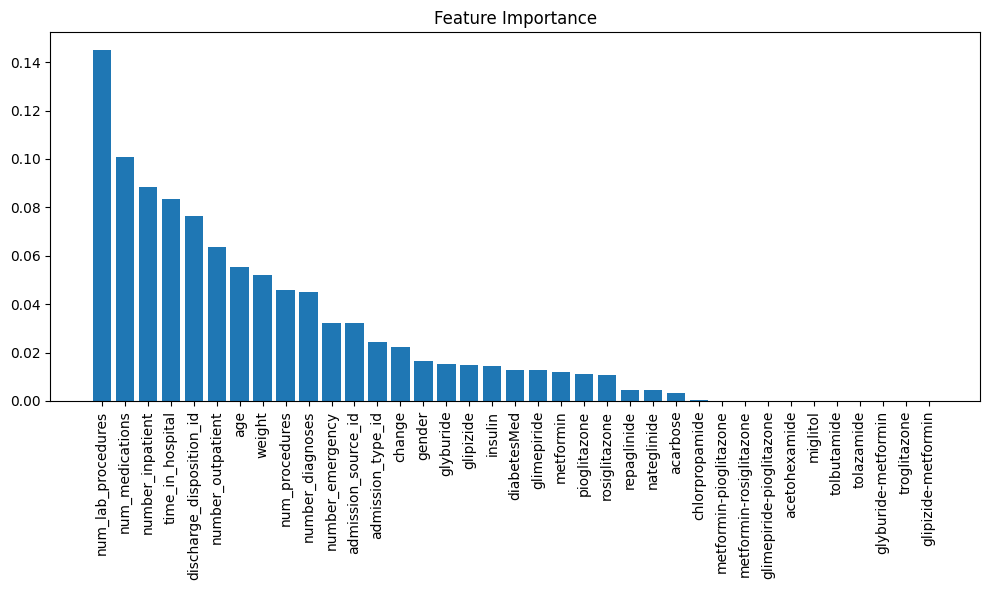

In [ ]:
best_weight = rf_downsampled_results[0][1]
importances = best_weight.feature_importances_
indices = np.argsort(importances)[::-1]

X = diabetic_df_filtered_withWeight.drop(columns=['readmitted'])
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

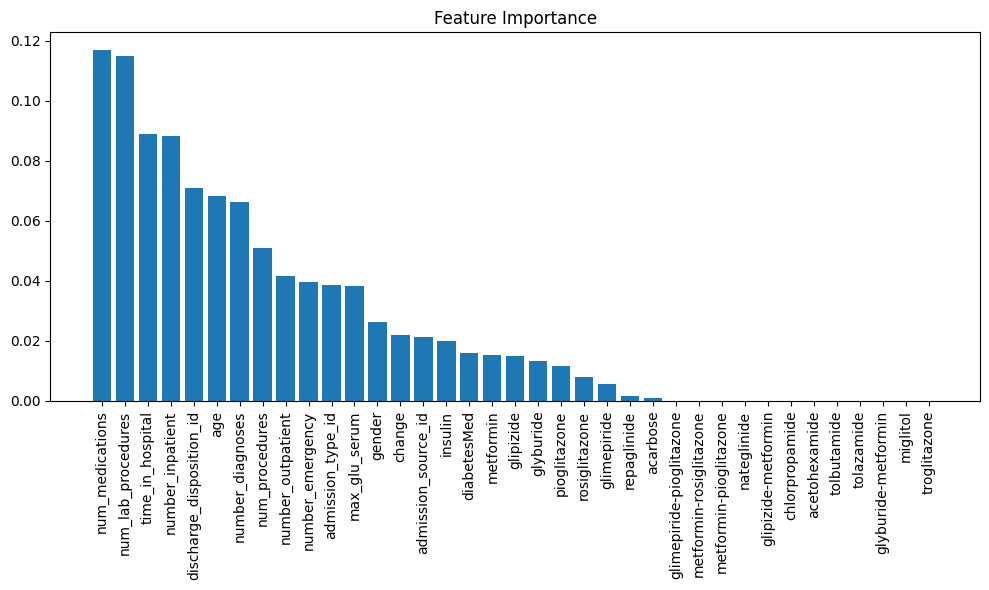

In [ ]:
best_maxglu = rf_downsampled_results[1][1]
importances = best_maxglu.feature_importances_
indices = np.argsort(importances)[::-1]

X = diabetic_df_filtered_withMaxGlu.drop(columns=['readmitted'])
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

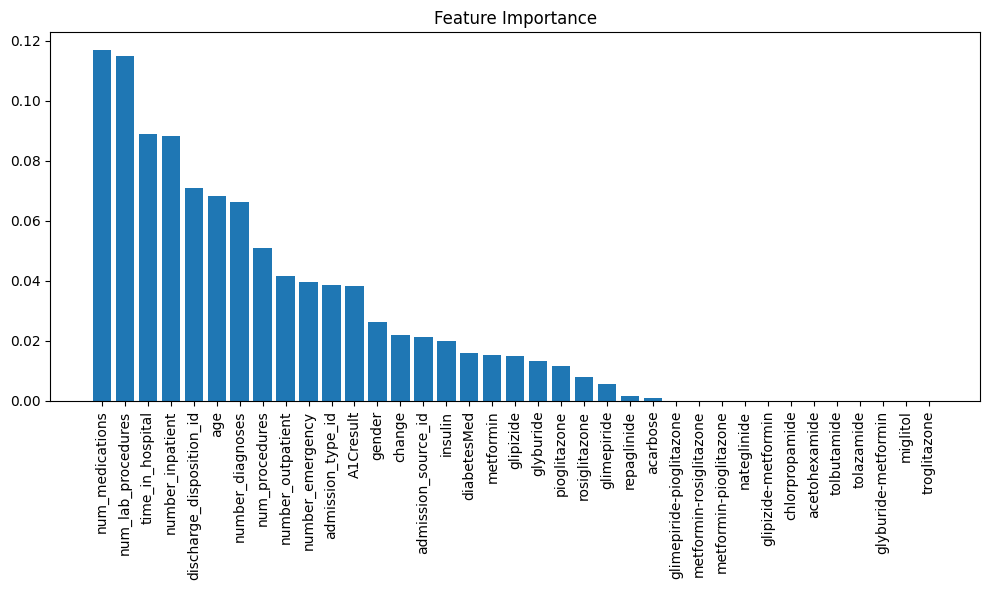

In [ ]:
best_A1C = rf_downsampled_results[1][1]
importances = best_A1C.feature_importances_
indices = np.argsort(importances)[::-1]

X = diabetic_df_filtered_withA1C.drop(columns=['readmitted'])
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Model 3. XGBoost

In [ ]:
def run_xgboost(df_encoded, model_name, param_grid=None):
    X = df_encoded.drop(columns=['readmitted'])
    y = df_encoded['readmitted']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Define base XGBoost model
    xgb = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    if param_grid:
        grid_search = GridSearchCV(
            estimator=xgb,
            param_grid=param_grid,
            scoring='f1',
            cv=5,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_xgb = grid_search.best_estimator_
        print(f"{model_name} — Best XGB Parameters: {grid_search.best_params_}")
    else:
        best_xgb = xgb.fit(X_train, y_train)

    y_prob = best_xgb.predict_proba(X_test)[:, 1]

    # Find optimal threshold from Youden's J
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    best_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[best_index]

    y_pred = (y_prob >= optimal_threshold).astype(int)

    print(f"{model_name} — Optimal Threshold: {optimal_threshold:.4f}")
    results = evaluate_model(y_test, y_pred, y_prob, model_name)

    return results, best_xgb


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5]
}

subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    "No weight": diabetic_df_filtered_withWeight.drop(columns=['weight']),
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    "No maxglu": diabetic_df_filtered_withMaxGlu.drop(columns=['max_glu_serum']),
    "A1C Only": diabetic_df_filtered_withA1C,
    "No A1C": diabetic_df_filtered_withA1C.drop(columns=['A1Cresult'])
}

xgb_results = []
for name, df in subsets.items():
    print(f"\n⚡️ Processing Subset (XGBoost): {name}")

    df_encoded = preprocess_subset(df)

    result, model = run_xgboost(df_encoded, f"XGBoost ({name})", param_grid)
    xgb_results.append(result)


⚡️ Processing Subset (XGBoost): Weight Only


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:45:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Weight Only) — Best XGB Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
XGBoost (Weight Only) — Optimal Threshold: 0.0138

⚡️ Processing Subset (XGBoost): No weight


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (No weight) — Best XGB Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
XGBoost (No weight) — Optimal Threshold: 0.1449

⚡️ Processing Subset (XGBoost): Max Glucose Only


KeyboardInterrupt: 

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5]
}

subsets = {
    "Weight Only": diabetic_df_filtered_withWeight,
    # "No weight": diabetic_df_filtered_withWeight.drop(columns=['weight']),
    "Max Glucose Only": diabetic_df_filtered_withMaxGlu,
    # "No maxglu": diabetic_df_filtered_withMaxGlu.drop(columns=['max_glu_serum']),
    "A1C Only": diabetic_df_filtered_withA1C,
    # "No A1C": diabetic_df_filtered_withA1C.drop(columns=['A1Cresult'])
}

xgb_downsampled_results = []
for name, df in subsets.items():
    print(f"\n⚡️ Processing Subset (XGBoost): {name}")

    df_encoded = preprocess_subset(df)


    df_downsampled = downsample_df(df_encoded)


    result, model = run_xgboost(df_downsampled, f"XGBoost ({name})", param_grid)
    xgb_downsampled_results.append(result)


⚡️ Processing Subset (XGBoost): Weight Only


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:21:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Weight Only) — Best XGB Parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}
XGBoost (Weight Only) — Optimal Threshold: 0.5090

⚡️ Processing Subset (XGBoost): Max Glucose Only


KeyboardInterrupt: 

### Model 4. Neural Network